# Bitcoin's Realized Volatility Forecasting with GARCH and Multivariate LSTM


## Обзор



С момента первого появления Биткойна в 2009 году он существенно изменил мировой финансовый ландшафт. Децентрализованная криптовалюта зарекомендовала себя как класс активов, признанный многими управляющими активами, крупными инвестиционными банками и хедж-фондами. Поскольку скорость массового внедрения криптоактивов продолжает расти, это также побуждает инвесторов изучать новые  криптовалютные опционы и фьючерсы.

Исторически известно, что биткойн более волатилен, чем регулируемые акции и сырьевые товары.

На момент написания этого отчета (середина марта 2024 года) биткойн торгуется по цене  70 000 долларов США, учитывая, что в 2020 году он стоил около 7200 долларов США.

Цель этого проекта - заглянуть в будущее, прогнозируя среднесуточную **реализованную волатильность** (RV) **BTC-USD**  на **следующие 7 дней**, используя 2 различных подхода - традиционный эконометрический подход к прогнозированию волатильности финансовых временных рядов **GARCH** и современные **нейронные сети LSTM**.

## Данные



Исторический набор данных о ценах открытия / закрытия ,  максимальных / минимальных ценах биткойна был получен с использованием Yahoo Finance API yfinance.

Я буду загружать цены BTC-USD с помощью тикера BTC-USD с интервалом в 1 день. рассмотрим период, охватывающий около 10 лет торговых дней (2014 - 2024)

### Installing & Importing Libraries



In [1]:
!pip install arch
!pip3 install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [4]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

In [5]:
print(os.path.join('..', '..', 'images'))

../../images


### Load Data from `yfinance`

In [6]:
# SET SEED FOR REPRODUCIBILITY
seed = 2021

In [7]:
# SELECT START AND END DATE
start = datetime(2014, 1, 1)
end = datetime(2024, 3, 31)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start,
                    end=end,
                    interval="1d")

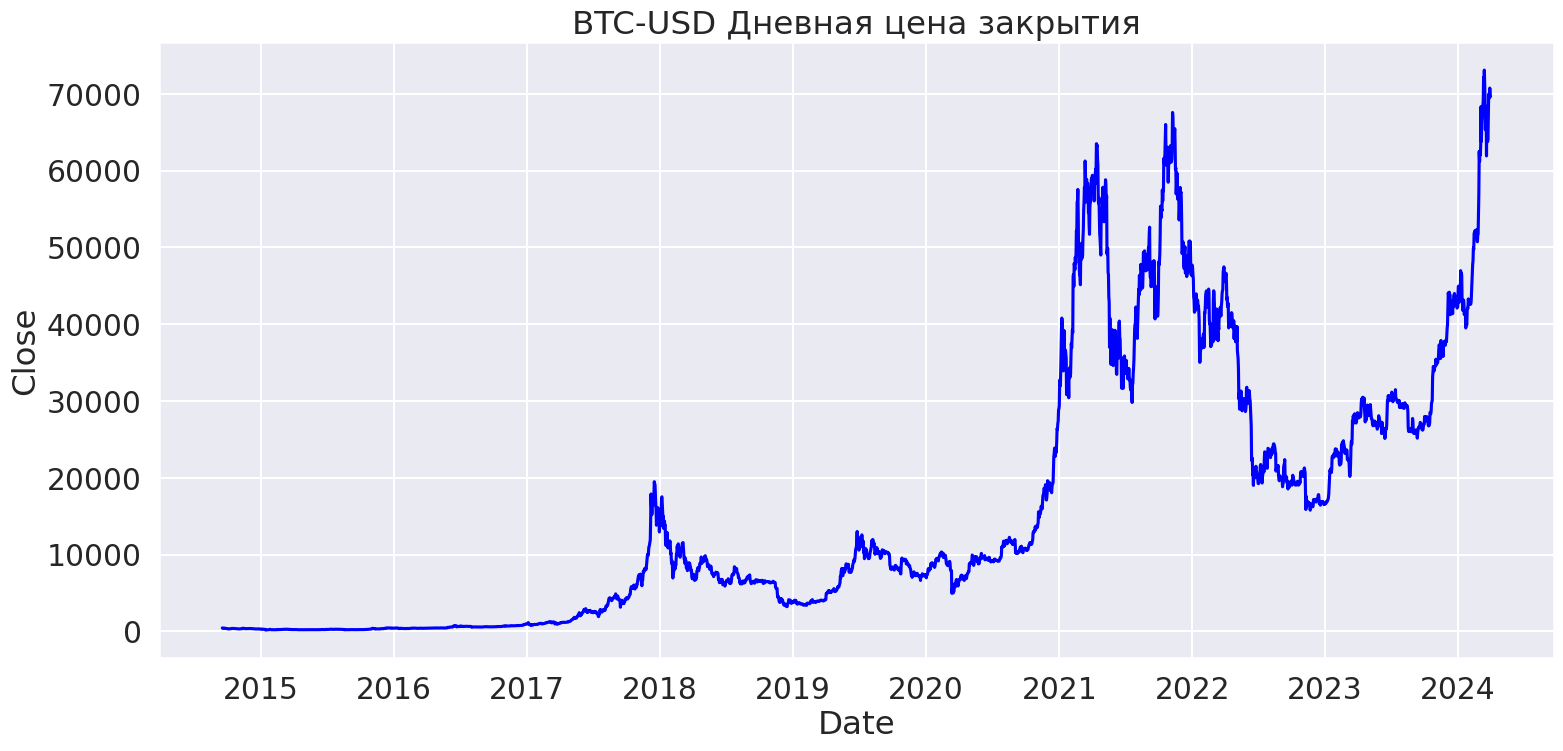

In [8]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Дневная цена закрытия')

# plt.tight_layout()
plt.savefig( 'close.png',dpi=300, bbox_inches='tight');

### **Типы волатильности и способы их измерения**

(Source: https://www.investopedia.com/terms/v/vix.asp)  





Волатильность пытается измерить величину ценовых колебаний, которые финансовый инструмент испытывает за определенный период времени. Чем резче колебания цен на этот инструмент, тем выше уровень волатильности, и наоборот.

Волатильность не измеряет направление изменений цен, а лишь их дисперсию. Это происходит потому, что при расчете стандартного отклонения (или дисперсии) все различия возводятся в квадрат, так что отрицательные и положительные различия объединяются в одну величину. Два инструмента с разной волатильностью могут иметь одинаковую ожидаемую доходность, но инструмент с более высокой
волатильностью будет иметь большие колебания стоимости за определенный период времени.
(источник: Википедия)

Волатильность может быть как исторической, так и подразумеваемой; и то, и другое обычно выражается в процентах.

•Историческая волатильность (HV) или Реализованная Волатильность  (**Historical Volatility** (HV) or **Realized Volatility**) - это фактическая волатильность, продемонстрированная базовым активом за определенный период времени, например за последний месяц или год. Реализованная волатильность обычно рассчитывается как стандартное отклонение доходности цены, которое представляет собой изменение цены в процентах от цены предыдущего дня.

•Подразумеваемая волатильность ( Implied volatility - IV), с другой стороны, представляет собой уровень волатильности базового актива, который подразумевается текущей ценой опциона.

In [9]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()



В практических целях обычно предпочтительнее использовать логарифмические результаты, особенно в математическом моделировании, поскольку это помогает устранить нестационарные свойства данных временных рядов, и делает их более стабильными:


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

Есть еще одно преимущество в доходности, выраженной в логарифме (log returns) -  аддитивность с течением времени: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$



In [10]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [11]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  Dividends  Stock Splits   returns  \
Date                                                                     
2014-09-17 00:00:00+00:00  21056800        0.0           0.0       NaN   
2014-09-18 00:00:00+00:00  34483200        0.0           0.0 -7.192558   
2014-09-19 00:00:00+00:00  37919700        0.0           0.0 -6.984265   
2014-09-20 00:00:00+00:00  36863600        0.0           0.0  3.573492   
2014-09-21 00:00:00+00:00  26580100        0.0           0.0 -2.465854   

                           log_returns  
Date                                    
2014-09-17 00:00:00+00:00          NaN  
2014-09-18 00:00:00+00:00    -0.074643  
2014-09-19 00:00:00+00:00    -0.072402  
2014-09-20 00:00:00+00:00     0.035111  
2014-09-21 00:00:00+00:00    -0.024968

In [12]:
# DROPPING THE 1ST ROW OF DATA
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

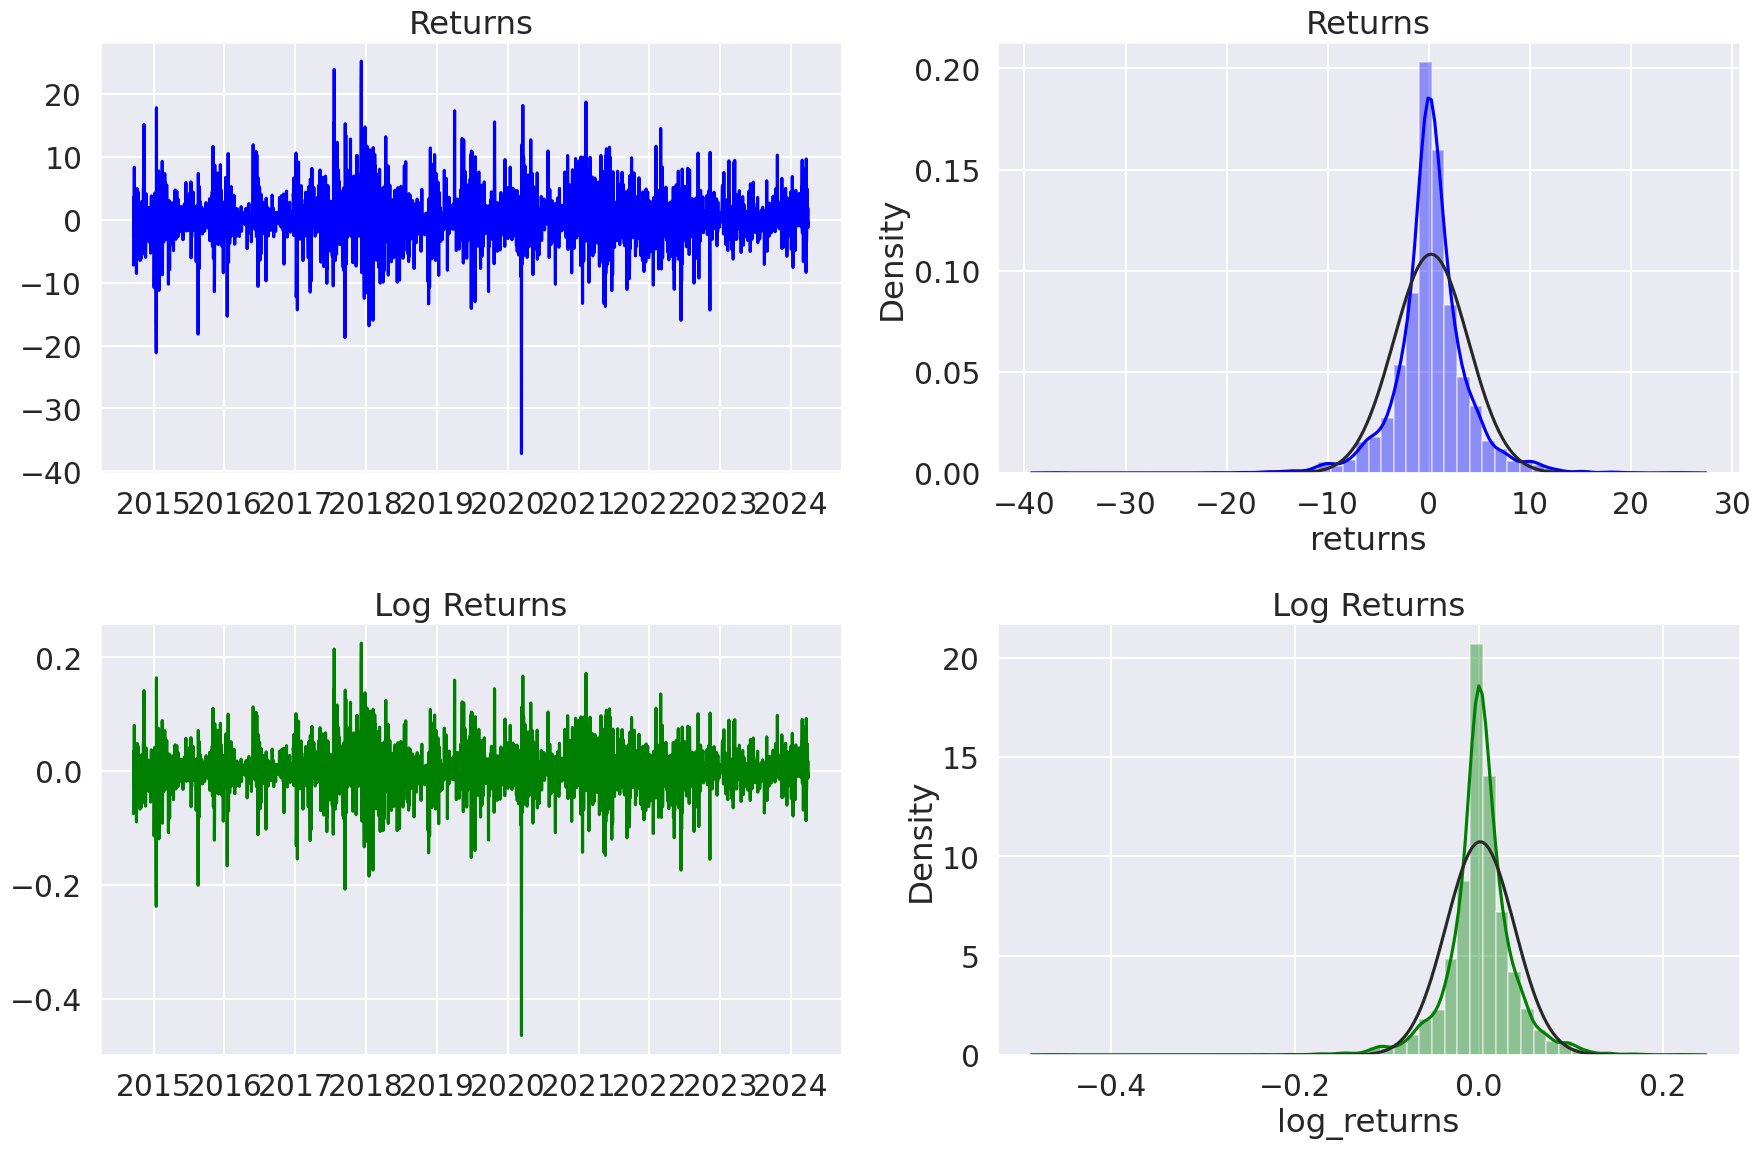

In [13]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    plt.savefig('returns_logreturns.png',
                dpi=300, bbox_inches='tight')
    fig.show();





графики доходностей Returns & Log Returns показывают :


•положительный эксцесс (лептокуртоз) - более высокий пик с более толстыми хвостами, чем при стандартном нормальном распределении.


In [14]:
df.returns.describe()

count    3482.000000
mean        0.212951
std         3.685972
min       -37.169539
25%        -1.240552
50%         0.139420
75%         1.719662
max        25.247169
Name: returns, dtype: float64

In [15]:
df.log_returns.describe()

count    3482.000000
mean        0.001443
std         0.037140
min        -0.464730
25%        -0.012483
50%         0.001393
75%         0.017050
max         0.225119
Name: log_returns, dtype: float64

(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)



Стандартное отклонение будет отличаться для логарифмической доходности, рассчитанной за более или менее продолжительные интервалы. Для данного  проекта волатильность будет соответствовать определенному окну с фиксированным интервалом (INTERVAL_WINDOW) - стандартное отклонение логарифмических доходностей, или квадратный корень из суммы квадратов логарифмической доходности:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$



И затем, чтобы масштабировать дневную волатильность с определенной частотой (еженедельно, ежемесячно, ежегодно), мы можем умножить дневную волатильность на квадратный корень из этой частоты в пересчете на день, деленный на интервал минус 1 (`INTERVAL_WINDOW - 1`). Например

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [16]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM  LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

### Выбор Интервального окна




Для этого проекта я буду использовать **интервал в 30 дней** (что эквивалентно примерно 1 месяцу торговли криптовалютами). Цель здесь состоит в том, чтобы спрогнозировать среднюю реализованную волатильность для последущих n_future 7 дней , использую все предыдущие доступные точки данных с моделями GARCH, а также с использованием ряда  прошлых / исторических точек данных (n_past) с
нейронными сетями (**прогнозирование с использованием скользящего окна**).


In [17]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)
vols_df.head(10)
# take the first value, 7, it means that the realized volatility for each data point is computed using the log returns of the previous 7 days.

7    30   60   180  365
Date                                                   
2014-09-18 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-19 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-20 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-21 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-22 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-23 00:00:00+00:00       NaN  NaN  NaN  NaN  NaN
2014-09-24 00:00:00+00:00  0.057809  NaN  NaN  NaN  NaN
2014-09-25 00:00:00+00:00  0.050425  NaN  NaN  NaN  NaN
2014-09-26 00:00:00+00:00  0.041475  NaN  NaN  NaN  NaN
2014-09-27 00:00:00+00:00  0.039237  NaN  NaN  NaN  NaN

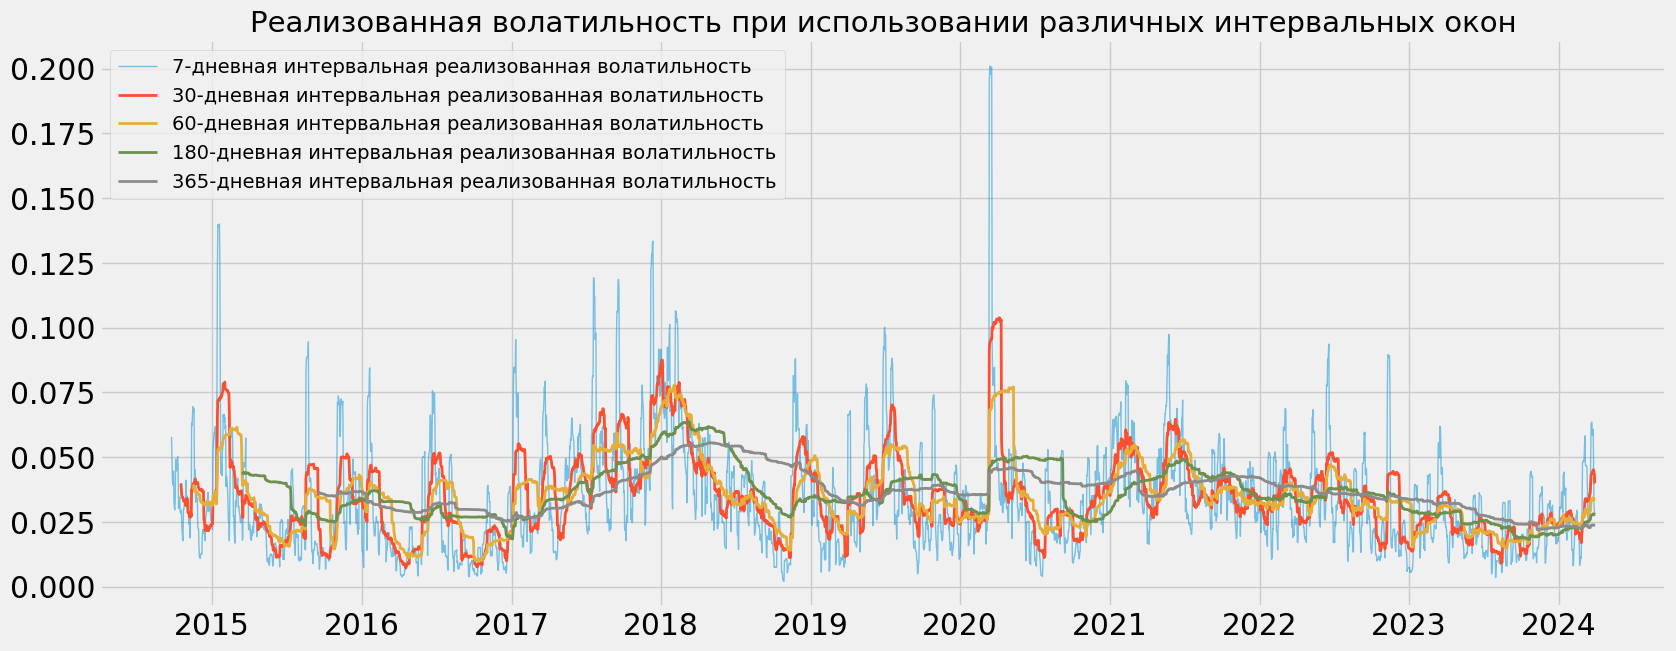

In [18]:
# CHANGING MATPLOTLIB STYLE
# alpha controls the transparency, lw sets the linewidth of the lines
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-дневная интервальная реализованная волатильность',
            alpha=alpha, lw=lw)

ax.set_title('Реализованная волатильность при использовании различных интервальных окон', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.savefig( 'diff_intervals.png',
            dpi=300, bbox_inches='tight')
plt.show();



Причина, по которой я выбрал 30 дней, заключается в том, что 7 дней кажутся слишком шумными для наблюдения значимых паттернов, в то время как более длительные интервалы, кажется, значительно сглаживают волатильность и имеют тенденцию возвращаться к среднему значению.

Использование интервала в 30 дней также помогло бы избежать потери слишком большого количества точек данных в начале набора данных.

Модели прогнозирования временных рядов - это модели, которые способны предсказывать будущие значения на основе ранее наблюдавшихся значений. Целевые "будущие" данные в этом случае получаются путем сдвига текущей волатильности назад на количество лагов  `n_future`.

Например, по сравнению с понедельником на прошлой неделе, понедельник на этой неделе является "будущим"; поэтому мне просто нужно сместить волатильность на этой неделе на 7 дней назад и использовать ее как желаемый результат "будущего"
для прошлой недели, который я затем использовал бы для обучения нейронных сетей и оценки производительности модели

In [19]:
INTERVAL_WINDOW = 30
n_future = 7
# the number of days into the future for forward-looking realized volatility

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [20]:
df

Open          High           Low  \
Date                                                                  
2014-09-18 00:00:00+00:00    456.859985    456.859985    413.104004   
2014-09-19 00:00:00+00:00    424.102997    427.834991    384.532013   
2014-09-20 00:00:00+00:00    394.673004    423.295990    389.882996   
2014-09-21 00:00:00+00:00    408.084991    412.425995    393.181000   
2014-09-22 00:00:00+00:00    399.100006    406.915985    397.130005   
...                                 ...           ...           ...   
2024-03-26 00:00:00+00:00  69931.328125  71535.742188  69335.609375   
2024-03-27 00:00:00+00:00  69991.898438  71727.687500  68381.929688   
2024-03-28 00:00:00+00:00  69452.773438  71546.023438  68895.507812   
2024-03-29 00:00:00+00:00  70744.796875  70913.093750  69076.656250   
2024-03-30 00:00:00+00:00  69893.445312  70355.492188  69601.062500   

                                  Close       Volume  Dividends  Stock Splits  \
Date                                                                            
2014-09-18 00:00:00+00:00    424.440002     34483200        0.0           0.0   
2014-09-19 00:00:00+00:00    394.795990     37919700        0.0           0.0   
2014-09-20 00:00:00+00:00    408.903992     36863600        0.0           0.0   
2014-09-21 00:00:00+00:00    398.821014     26580100        0.0           0.0   
2014-09-22 00:00:00+00:00    402.152008     24127600        0.0           0.0   
...                                 ...          ...        ...           ...   
2024-03-26 00:00:00+00:00  69987.835938  36010437368        0.0           0.0   
2024-03-27 00:00:00+00:00  69455.343750  40827113309        0.0           0.0   
2024-03-28 00:00:00+00:00  70744.953125  34374900617        0.0           0.0   
2024-03-29 00:00:00+00:00  69892.828125  25230851763        0.0           0.0   
2024-03-30 00:00:00+00:00  69645.304688  17130241883        0.0           0.0   

                            returns  log_returns  vol_current  vol_future  
Date                                                                       
2014-09-18 00:00:00+00:00 -7.192558    -0.074643          NaN         NaN  
2014-09-19 00:00:00+00:00 -6.984265    -0.072402          NaN         NaN  
2014-09-20 00:00:00+00:00  3.573492     0.035111          NaN         NaN  
2014-09-21 00:00:00+00:00 -2.465854    -0.024968          NaN         NaN  
2014-09-22 00:00:00+00:00  0.835210     0.008317          NaN         NaN  
...                             ...          ...          ...         ...  
2024-03-26 00:00:00+00:00  0.041486     0.000415     0.045104         NaN  
2024-03-27 00:00:00+00:00 -0.760835    -0.007637     0.044061         NaN  
2024-03-28 00:00:00+00:00  1.856746     0.018397     0.043362         NaN  
2024-03-29 00:00:00+00:00 -1.204503    -0.012118     0.040021         NaN  
2024-03-30 00:00:00+00:00 -0.354147    -0.003548     0.039834         NaN  

[3482 rows x 11 columns]

In [21]:
df.describe()

Open          High           Low         Close        Volume  \
count   3482.000000   3482.000000   3482.000000   3482.000000  3.482000e+03   
mean   15571.346141  15937.434132  15184.475838  15589.961963  1.701140e+10   
std    17195.825184  17615.058535  16744.797691  17215.768517  1.927276e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      996.378265   1012.012512    971.052505    998.539017  2.014223e+08   
50%     8598.533691   8755.779297   8325.447266   8598.909180  1.267487e+10   
75%    26465.479492  26797.032715  26070.901855  26479.333008  2.732425e+10   
max    73079.375000  73750.070312  71334.093750  73083.500000  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     3482.0        3482.0  3482.000000  3482.000000  3453.000000   
mean         0.0           0.0     0.212951     0.001443     0.034289   
std          0.0           0.0     3.685972     0.037140     0.015818   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.240552    -0.012483     0.023615   
50%          0.0           0.0     0.139420     0.001393     0.031996   
75%          0.0           0.0     1.719662     0.017050     0.042808   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  3446.000000  
mean      0.034287  
std       0.015834  
min       0.007228  
25%       0.023614  
50%       0.031950  
75%       0.042835  
max       0.103878

уберем колонки `Dividends` и `Stock Splits`

In [22]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [23]:
df.describe()

Open          High           Low         Close        Volume  \
count   3482.000000   3482.000000   3482.000000   3482.000000  3.482000e+03   
mean   15571.346141  15937.434132  15184.475838  15589.961963  1.701140e+10   
std    17195.825184  17615.058535  16744.797691  17215.768517  1.927276e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      996.378265   1012.012512    971.052505    998.539017  2.014223e+08   
50%     8598.533691   8755.779297   8325.447266   8598.909180  1.267487e+10   
75%    26465.479492  26797.032715  26070.901855  26479.333008  2.732425e+10   
max    73079.375000  73750.070312  71334.093750  73083.500000  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3482.000000  3482.000000  3453.000000  3446.000000  
mean      0.212951     0.001443     0.034289     0.034287  
std       3.685972     0.037140     0.015818     0.015834  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.240552    -0.012483     0.023615     0.023614  
50%       0.139420     0.001393     0.031996     0.031950  
75%       1.719662     0.017050     0.042808     0.042835  
max      25.247169     0.225119     0.103878     0.103878


Поскольку в настоящее время я использую INTERVAL_WINDOW, равный 30, с  n_future = 7 , волатильность первых 30 значений, а также последних 7 значений будет NaN , и следовательно, должны быть удалены из набора данных.



In [24]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

## **Предварительный анализ данных**



Сначала я бы просто наметил свои желаемые целевые результаты vol_future по  отношению к текущей волатильности vol_current. На первом графике показаны все доступные мне данные, которые охватывают 10 лет,  на втором графике показаны только последние 365 дней.

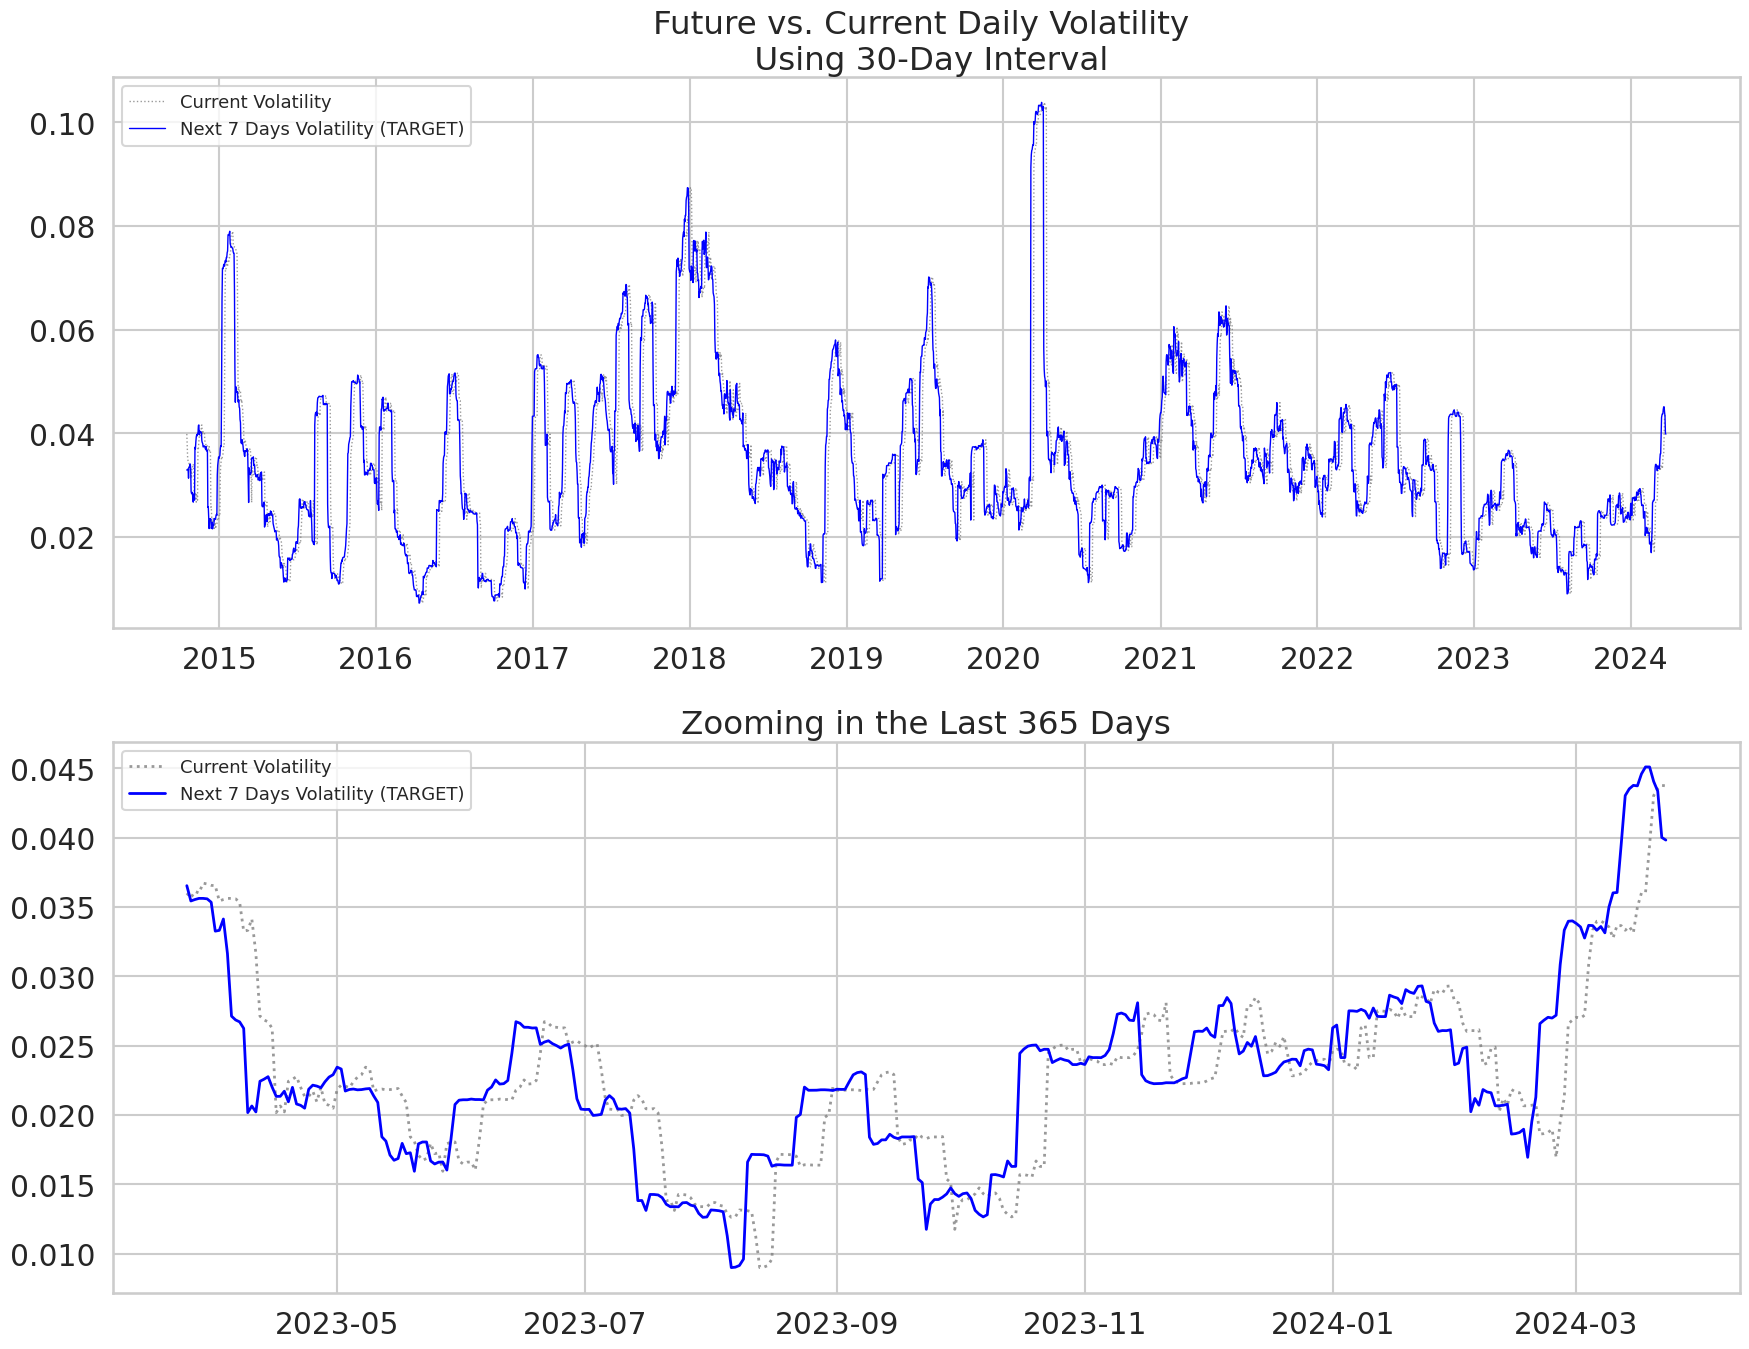

In [25]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.savefig('daily_vol.jpg',
                dpi=300, bbox_inches='tight')
    plt.show();



На графике выше **синяя линия** указывает на целевое будущее значение **target future**, которому прогноз должен соответствовать в лучшем случае.

А пунктирная **серая линия** представляет текущую волатильность **current volatility** в режиме реального времени.


### **Дневная Волатильность, Сгруппированная по месяцам**

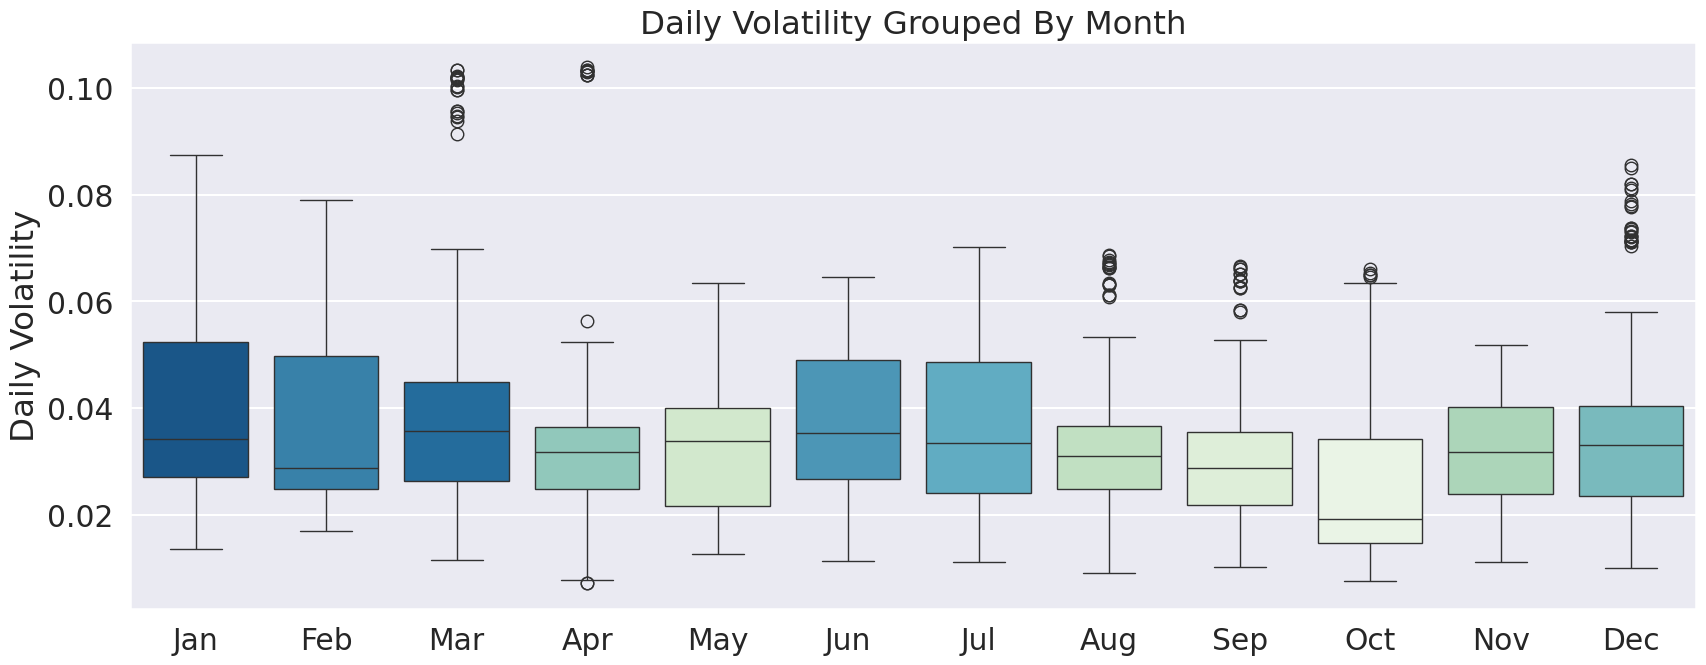

In [26]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun',
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
# calculate the average daily volatility for each month
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()


# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df.vol_current,
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')
    plt.savefig("vol_by_month.png",
                dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03



Можно заметить , что:

•исторически волатильность стабильно достигала некоторых из своих самых высоких значений в декабре

•Наибольшее количество крупных выбросов приходится  на март и апрель


### **Daily Volatility Grouped by Year**

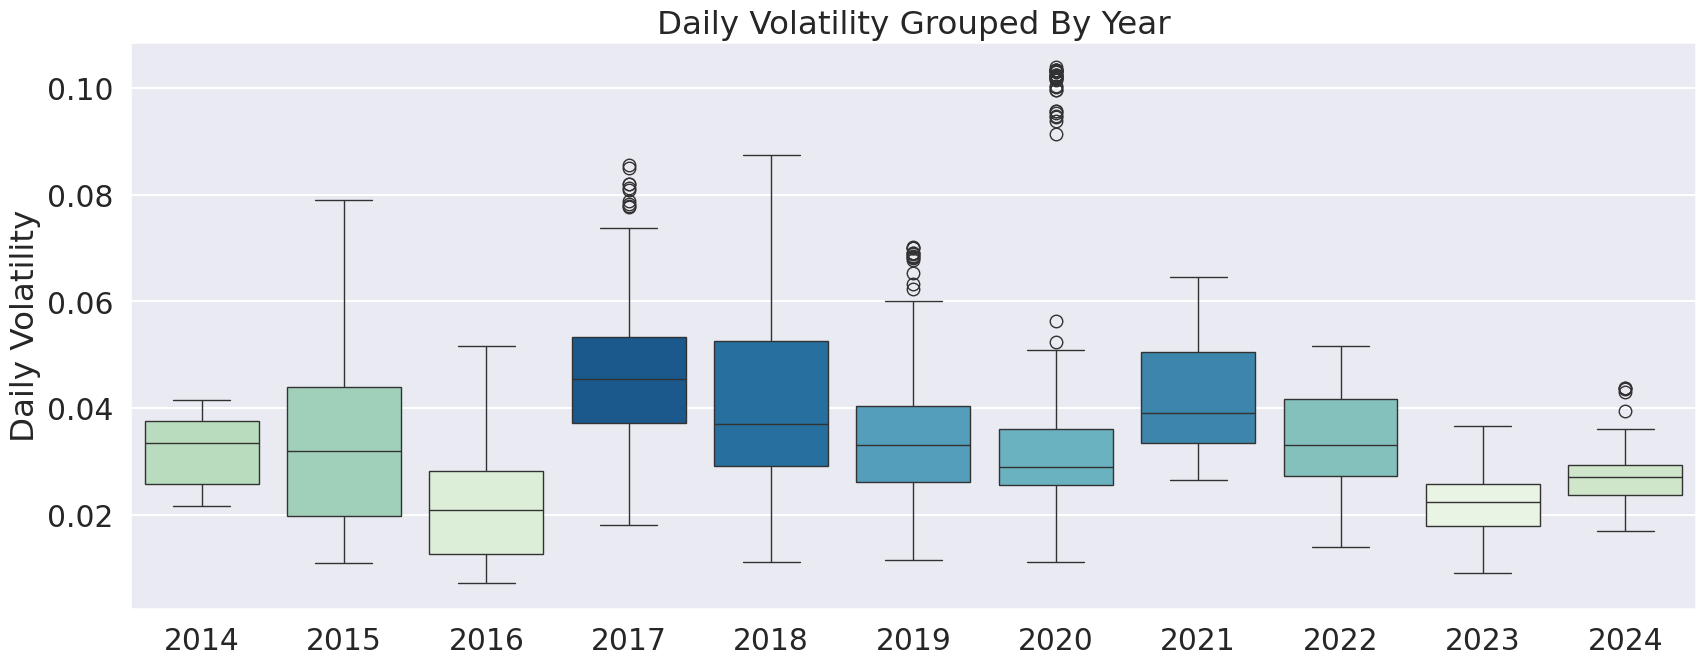

In [28]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=df.index.year,
                y=df.vol_current,
                palette=np.array(pal)[rank])
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Year')
    plt.savefig( "vol_by_year.png",
                dpi=300, bbox_inches='tight')
    plt.show()





За прошлые годы  криптовалюты претерпели некоторые структурные изменения, которые напрямую повлияли на волатильность, такие как:
- Крипто опционы стали доступны на бирже деривативов на криптовалюту Deribit в 2016 году
- Фьючерсы на биткоин были предложены в 2017 году на Чикагской товарной бирже (CME), которая представляет собой организованную биржу для торговли фьючерсами и опционами
- Затем запуск торгов биткоин-опционами на CME

Эти события позволили людям более эффективно торговать криптовалютами

Мы можем видеть эти крупные события, отраженные на графике выше - первый рекордный пик биткоина в 2017 году (около 19 800 долларов США к концу декабря).
 И выбросы в 2020 году соответствовали его более чем 200%-ному росту в 2020 году (цена биткойна составляла 7200 долларов США в начале 2020 года). В середине декабря 2020 года он достиг 20 000 долларов США на большинстве бирж, а затем всего 17 дней спустя достиг 30 000 долларов США, что является значительным достижением. Чтобы лучше оценить масштабы роста, обратимся к индексу Доу-Джонса, которому потребовалось почти 3 года для достижения схожего результата.

Можно заметить, что общая дневная волатильность в 2021 году также была выше чем в прошлый год. В период 2022-2024 произошло значительное снижение этого показателя.

  На момент написания этого отчета (середина марта 2024 года) биткойн торгуется по цене 70 000 долларов США.


### **Дневное распределение волатильности**

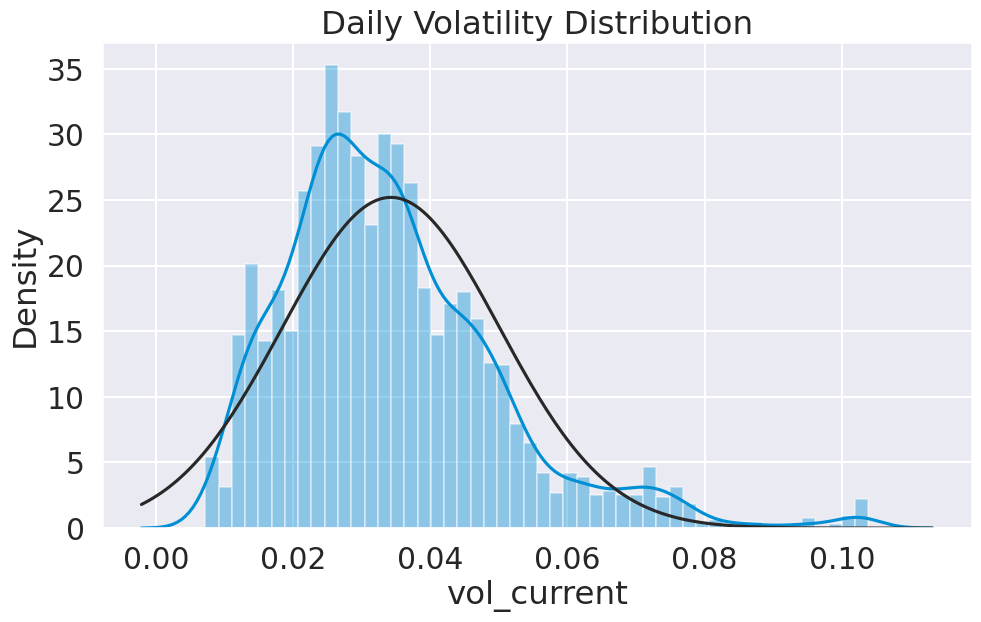

In [29]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.savefig("vol_dist.png",
                dpi=300, bbox_inches='tight')
    plt.show();


Распределение реализованной дневной волатильности слегка смещено вправо, с небольшим количеством больших значений, разбросанных  справа.

Смещенное вправо распределение будет иметь меньшую медиану по сравнению со средним значением, а моду - меньшую,чем медиана (мода < медиана < среднее).

### **проверка стационарности доходности/Log доходности**




Когда мы создаем прогнозирующую Модель  для временных рядов, нам требуются стационарные временные ряды, то есть обладающие одинаковой Ковариацией Выборок одного размера. Ковариация — мера взаимосвязи двух случайных величин, измеряющая общее отклонение двух случайных величин от их ожидаемых значений. Метрика оценивает, в какой степени переменные изменяются вместе. Другими словами, это мера Дисперсии между двумя переменными.

Тестирование на стационарность часто используется в Авторегрессионных моделях. Мы можем выполнять различные тесты, такие как Критерий KPSS, Тест Филлипса — Перрона (Phillips-Perron Test) и ADF. Мы рассмотрим ADF тест.

Augmented Dickey-Fuller test

Тест ADF (расширенный тест Дики — Фуллера) — проверка Статистической значимости, которая демонстрирует результаты проверки Нулевой гипотезы (Null Hypothesis) и Альтернативной (Alternative Hypothesis). В результате мы получим P-значение (P Value), из которого можно сделать вывод о Стационарности Временного ряда
- Нулевая гипотеза - данные нестационарные

- если p-value значение теста меньше α, то ряд стационарен.


In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')

for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -17.738102657642905
p-value: 3.411636304540719e-30
Critical Values:
1%: -3.4323
5%: -2.8624
10%: -2.5672


In [32]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -60.09898026024235
p-value: 0.0
Critical Values:
1%: -3.4322
5%: -2.8624
10%: -2.5672



Используя уровень значимости  альфа, равный 0,05, `p-value` как для доходности, так и для логарифмических доходности значительно меньше альфа, что означает, что имеется достаточно доказательств для отклонения нулевой гипотезы.
Данные Returns и Log returns стационарны, отсутствует зависимость данных от времени и тренда.


## **Разделение данных для тренировки , валидации и тестирования модели**



 Поскольку криптовалюты не торгуются на регулируемой бирже, рынок биткоинов открыт 24/7, 1 год охватывает целых 365 торговых дней вместо 252 дней в году, как в случае с другими акциями и сырьевыми товарами.

Я бы разделил набор данных на 3 части следующим образом:

- для окончательного **тестирования** модели будут использоваться 30 последних доступных точек данных

- 1 полный год (365 дней) на **валидацию и настройку модели** во время обучения

- оставшиеся данные - для **обучения**


In [33]:
len(df) # количество наблюдений

3446

In [34]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# split_time_1 - the dataset between the training and validation sets.
# split_time_2 - the dataset between the validation and test sets.

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [35]:
val_idx

DatetimeIndex(['2023-02-23 00:00:00+00:00', '2023-02-24 00:00:00+00:00',
               '2023-02-25 00:00:00+00:00', '2023-02-26 00:00:00+00:00',
               '2023-02-27 00:00:00+00:00', '2023-02-28 00:00:00+00:00',
               '2023-03-01 00:00:00+00:00', '2023-03-02 00:00:00+00:00',
               '2023-03-03 00:00:00+00:00', '2023-03-04 00:00:00+00:00',
               ...
               '2024-02-13 00:00:00+00:00', '2024-02-14 00:00:00+00:00',
               '2024-02-15 00:00:00+00:00', '2024-02-16 00:00:00+00:00',
               '2024-02-17 00:00:00+00:00', '2024-02-18 00:00:00+00:00',
               '2024-02-19 00:00:00+00:00', '2024-02-20 00:00:00+00:00',
               '2024-02-21 00:00:00+00:00', '2024-02-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=365, freq=None)

In [36]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2023-02-22 00:00:00+00:00 	3051 days
VALIDATION 	From: 2023-02-23 00:00:00+00:00 	to: 2024-02-22 00:00:00+00:00 	365 days
TEST 		From: 2024-02-23 00:00:00+00:00 	to: 2024-03-23 00:00:00+00:00 	30 days






Целью здесь будет `vol_future`, который представляет ежедневную реализованную волатильность следующих `n_future` дней с сегодняшнего дня (среднесуточная волатильность от `t + n_future - INTERVAL_WINDOW`к временному шагу `t + n_future`).

Например, используя n_future = 7 и INTERVAL_WINDOW = 30, значение которое я хочу спрогнозировать с шагом по времени `t` будет среднесуточная реализованная волатильность, начиная с шага t-22 до шага по времени t+7 .


In [37]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [38]:
df

Open          High           Low  \
Date                                                                  
2014-10-17 00:00:00+00:00    382.756012    385.477997    375.389008   
2014-10-18 00:00:00+00:00    383.976013    395.157990    378.971008   
2014-10-19 00:00:00+00:00    391.253998    393.938995    386.457001   
2014-10-20 00:00:00+00:00    389.230988    390.084015    378.252014   
2014-10-21 00:00:00+00:00    382.420990    392.645996    380.834015   
...                                 ...           ...           ...   
2024-03-19 00:00:00+00:00  67556.132812  68106.929688  61536.179688   
2024-03-20 00:00:00+00:00  61930.156250  68115.257812  60807.785156   
2024-03-21 00:00:00+00:00  67911.585938  68199.992188  64580.917969   
2024-03-22 00:00:00+00:00  65489.929688  66623.750000  62355.371094   
2024-03-23 00:00:00+00:00  63802.722656  65976.398438  63038.492188   

                                  Close       Volume   returns  log_returns  \
Date                                                                          
2014-10-17 00:00:00+00:00    383.757996     13600700  0.314201     0.003137   
2014-10-18 00:00:00+00:00    391.441986     11416800  2.002301     0.019825   
2014-10-19 00:00:00+00:00    389.545990      5914570 -0.484362    -0.004855   
2014-10-20 00:00:00+00:00    382.845001     16419000 -1.720205    -0.017352   
2014-10-21 00:00:00+00:00    386.475006     14188900  0.948166     0.009437   
...                                 ...          ...       ...          ...   
2024-03-19 00:00:00+00:00  61912.773438  74215844794 -8.343357    -0.087121   
2024-03-20 00:00:00+00:00  67913.671875  66792634382  9.692505     0.092511   
2024-03-21 00:00:00+00:00  65491.390625  44480350565 -3.566706    -0.036319   
2024-03-22 00:00:00+00:00  63778.761719  41401116964 -2.615044    -0.026498   
2024-03-23 00:00:00+00:00  64062.203125  24738964812  0.444413     0.004434   

                           vol_current  vol_future  
Date                                                
2014-10-17 00:00:00+00:00     0.039872    0.032900  
2014-10-18 00:00:00+00:00     0.037566    0.033009  
2014-10-19 00:00:00+00:00     0.035089    0.033083  
2014-10-20 00:00:00+00:00     0.034629    0.033017  
2014-10-21 00:00:00+00:00     0.034362    0.031334  
...                                ...         ...  
2024-03-19 00:00:00+00:00     0.039483    0.045104  
2024-03-20 00:00:00+00:00     0.043041    0.044061  
2024-03-21 00:00:00+00:00     0.043529    0.043362  
2024-03-22 00:00:00+00:00     0.043777    0.040021  
2024-03-23 00:00:00+00:00     0.043743    0.039834  

[3446 rows x 9 columns]

In [39]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [40]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [41]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [42]:
y_train.describe()

count    3051.000000
mean        0.035668
std         0.016135
min         0.007228
25%         0.025005
50%         0.033471
75%         0.044280
max         0.103878
Name: vol_future, dtype: float64

In [43]:
x_train.describe()

count    3051.000000
mean        0.035689
std         0.016129
min         0.007228
25%         0.025005
50%         0.033542
75%         0.044280
max         0.103878
Name: vol_current, dtype: float64

## **Предварительная обработка данных**

### 1. Нормализация функций



Поскольку я собираюсь строить различные типы моделей на основе  алгоритмов с использованием разных типов входных данных, было бы лучше нормализовать волатильность, чтобы стандартизировать прогнозы, генерируемые разными моделями. Для этой цели будем  использовать `MinMaxScaler`.


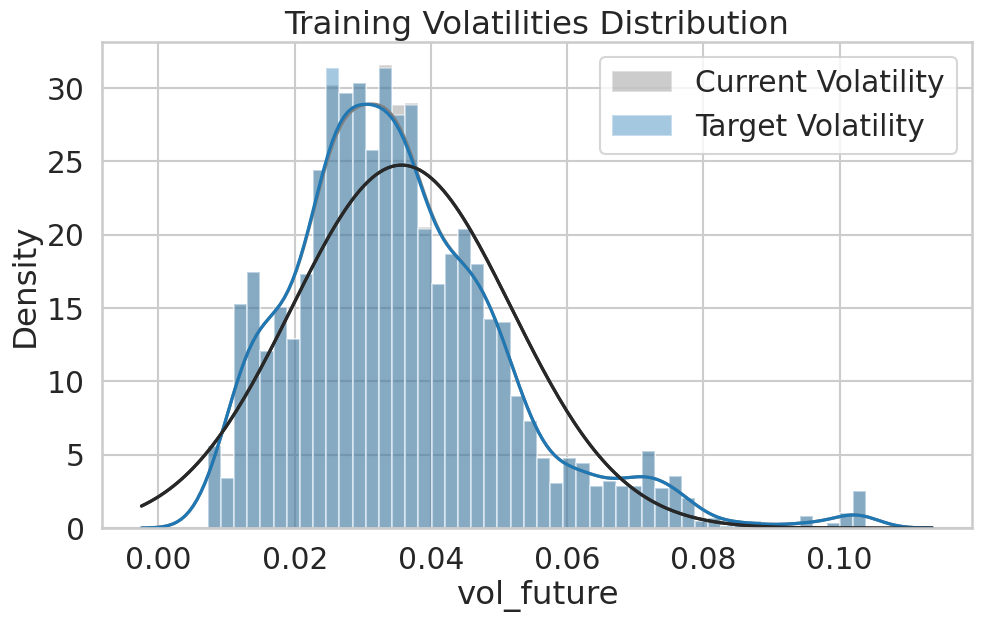

In [44]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.savefig("vol_dist.png",
                dpi=300, bbox_inches='tight')
    plt.show();

In [45]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [46]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [47]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [48]:
x_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.039872
2014-10-18 00:00:00+00:00    0.037566
2014-10-19 00:00:00+00:00    0.035089
2014-10-20 00:00:00+00:00    0.034629
2014-10-21 00:00:00+00:00    0.034362
2014-10-22 00:00:00+00:00    0.034364
2014-10-23 00:00:00+00:00    0.033347
2014-10-24 00:00:00+00:00    0.032900
2014-10-25 00:00:00+00:00    0.033009
2014-10-26 00:00:00+00:00    0.033083
Name: vol_current, dtype: float64

In [49]:
y_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.032900
2014-10-18 00:00:00+00:00    0.033009
2014-10-19 00:00:00+00:00    0.033083
2014-10-20 00:00:00+00:00    0.033017
2014-10-21 00:00:00+00:00    0.031334
2014-10-22 00:00:00+00:00    0.033474
2014-10-23 00:00:00+00:00    0.033426
2014-10-24 00:00:00+00:00    0.033602
2014-10-25 00:00:00+00:00    0.034075
2014-10-26 00:00:00+00:00    0.033154
Name: vol_future, dtype: float64

In [50]:
x_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.337754
2014-10-18 00:00:00+00:00    0.313894
2014-10-19 00:00:00+00:00    0.288269
2014-10-20 00:00:00+00:00    0.283501
2014-10-21 00:00:00+00:00    0.280738
2014-10-22 00:00:00+00:00    0.280764
2014-10-23 00:00:00+00:00    0.270238
2014-10-24 00:00:00+00:00    0.265613
2014-10-25 00:00:00+00:00    0.266743
2014-10-26 00:00:00+00:00    0.267507
dtype: float64

In [51]:
y_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.265613
2014-10-18 00:00:00+00:00    0.266743
2014-10-19 00:00:00+00:00    0.267507
2014-10-20 00:00:00+00:00    0.266830
2014-10-21 00:00:00+00:00    0.249415
2014-10-22 00:00:00+00:00    0.271550
2014-10-23 00:00:00+00:00    0.271058
2014-10-24 00:00:00+00:00    0.272883
2014-10-25 00:00:00+00:00    0.277768
2014-10-26 00:00:00+00:00    0.268242
dtype: float64

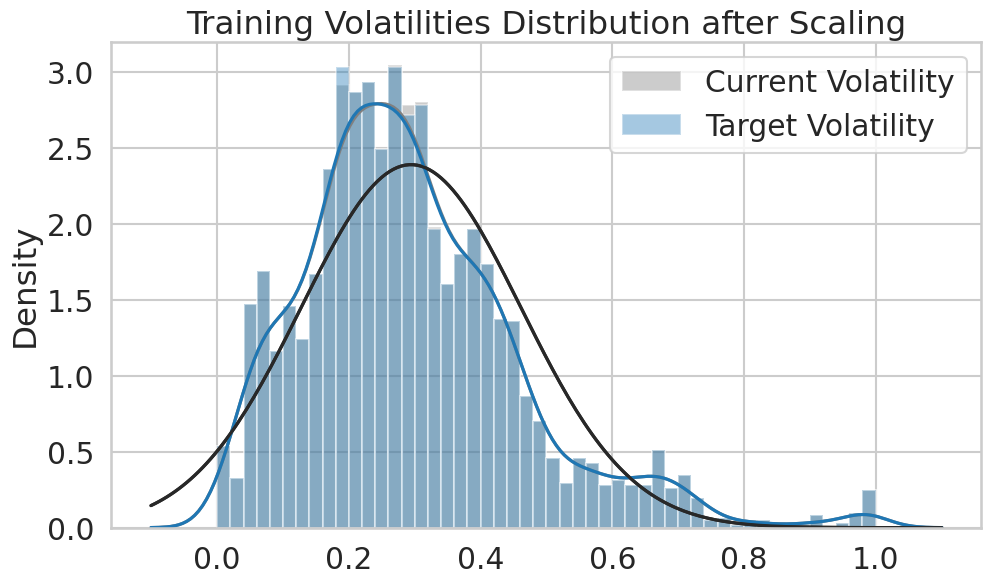

In [52]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.savefig( "vol_dist.png",
                dpi=300, bbox_inches='tight')
    plt.show();

### 2. Train-Validation-Test Visualization

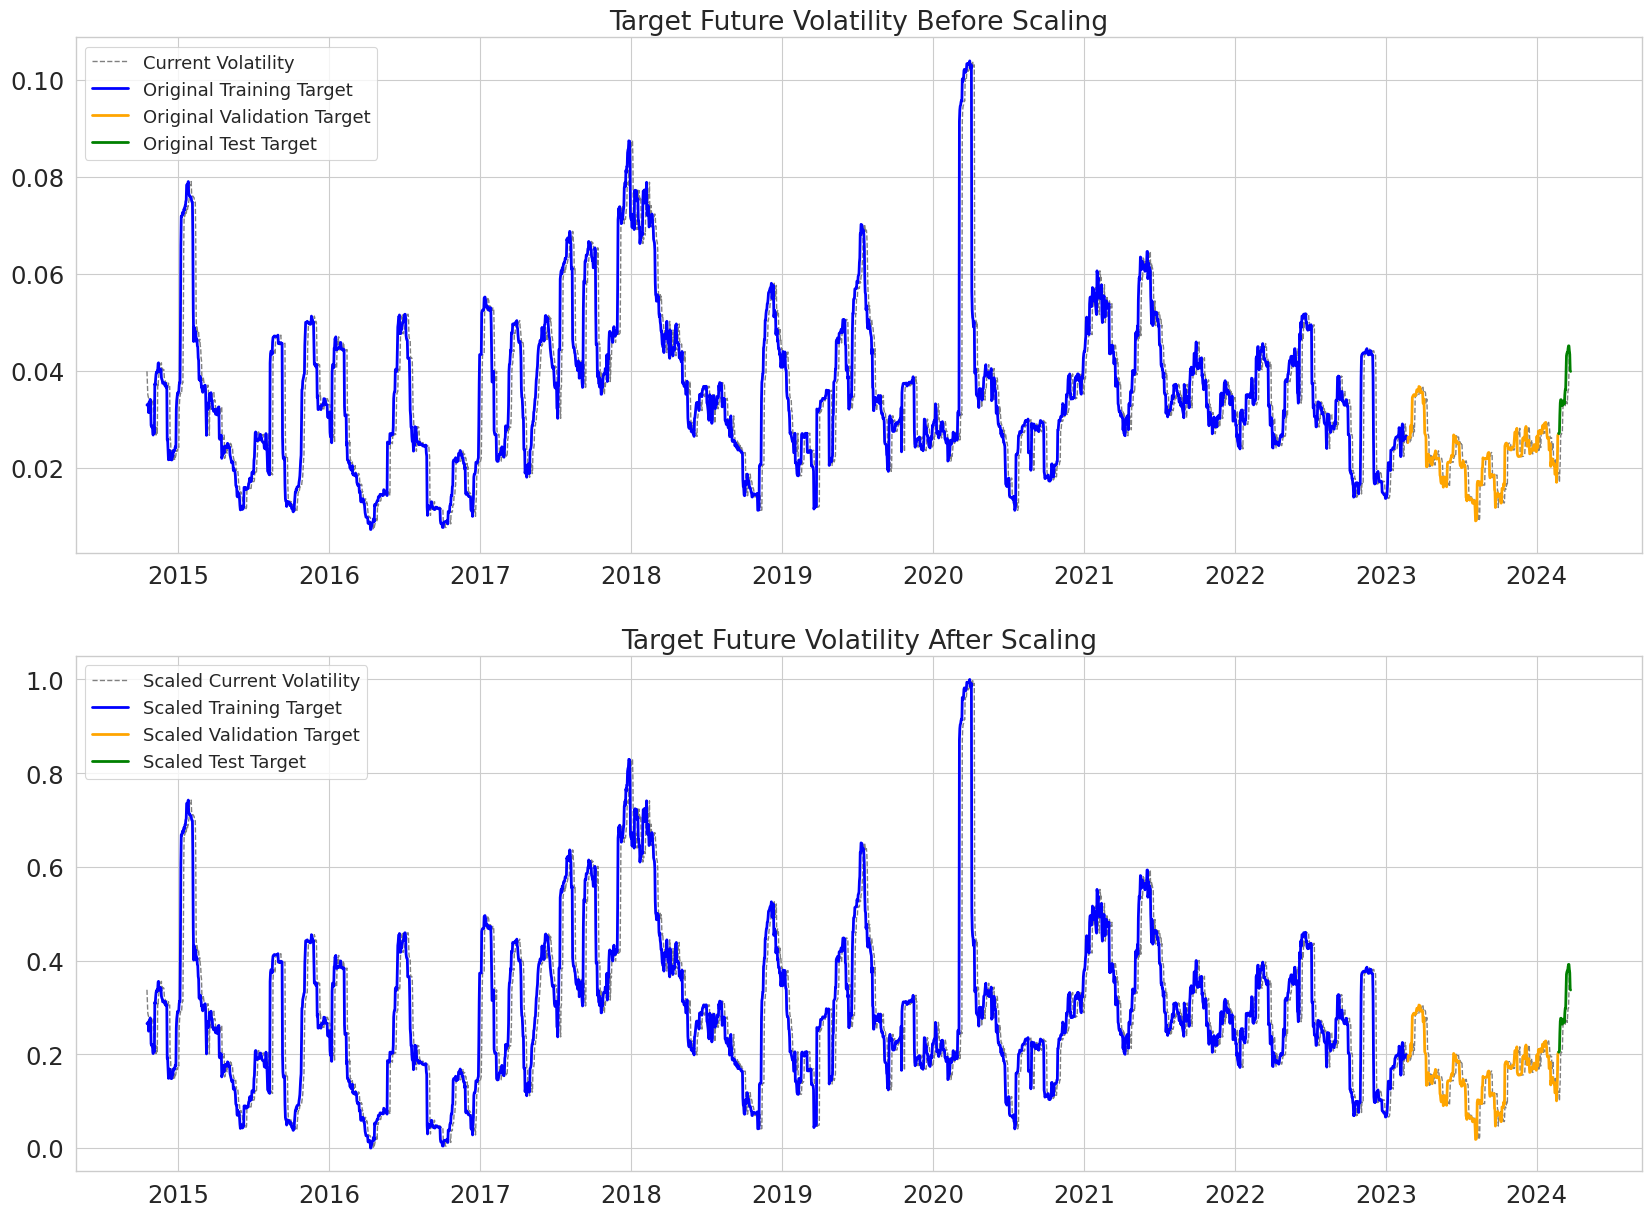

In [53]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER scaling
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current),
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.savefig(os.path.join('train_val_test_org_scled.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

Одним из наиболее очевидных различий между двумя графиками является ось y.  значения волатильности попадают в диапазон [0,1] после масштабирования вместо [0, 0,12] , как раньше.

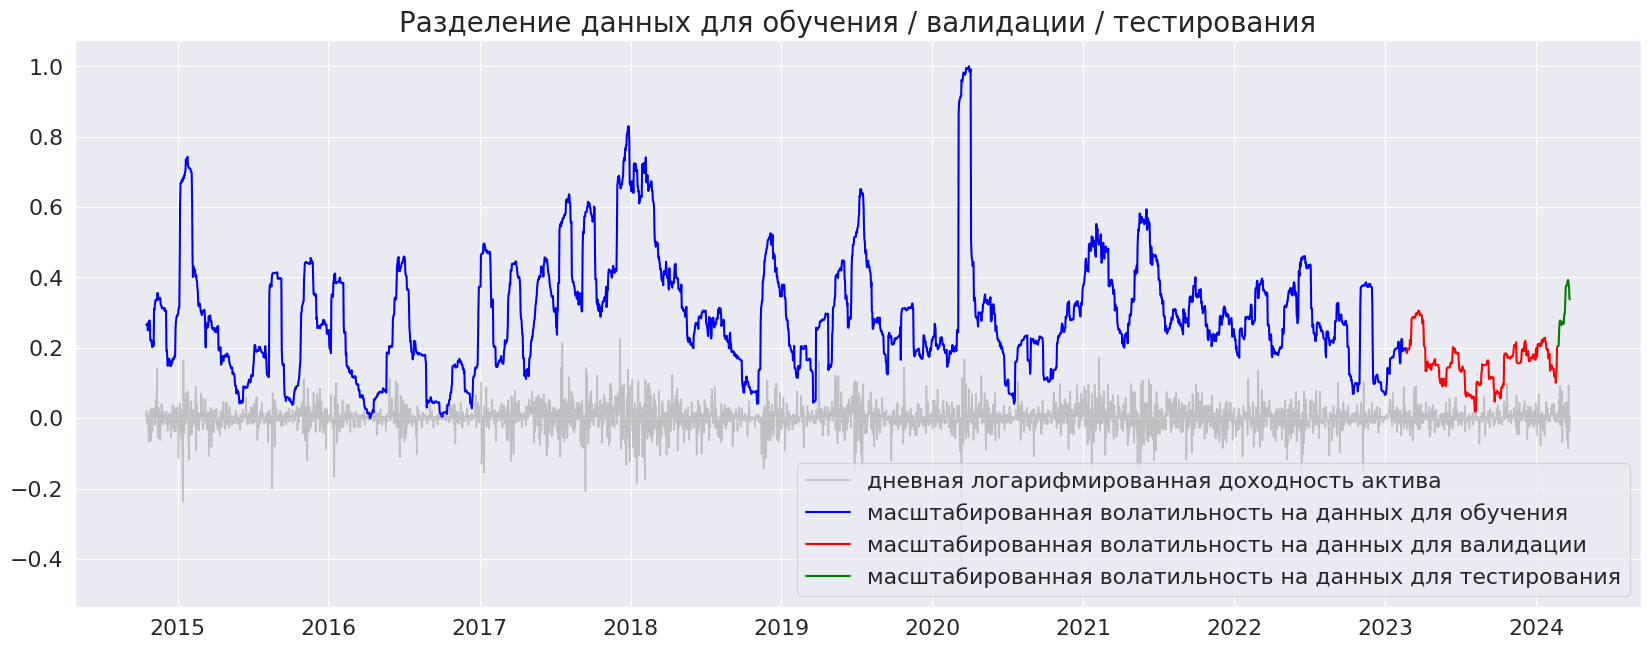

In [54]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='дневная логарифмированная доходность актива', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='масштабированная волатильность на данных для обучения', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='масштабированная волатильность на данных для валидации', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='масштабированная волатильность на данных для тестирования', lw=1.5)

    plt.plot()
    plt.title('Разделение данных для обучения / валидации / тестирования', fontsize=20)
    plt.legend(frameon=True)
    plt.savefig(os.path.join('train_val_test.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

# МОДЕЛИРОВАНИЕ

## 1. Показатели эффективности

источник https://datasciencebook.ca/regression1.html

FORMULA SOURCE https://s2.smu.edu/tfomby/eco5385_eco6380/lecture/Scoring%20Measures%20for%20Prediction%20Problems.pdf
Показатели эффективности прогнозов модели

При изучении финансовых временных рядов и тестировании различных подходов и параметров, мы, вероятно, найдем стратегию, которая успешно прогнозирует данные в выборке. Однако цель прогнозирования заключается в предсказании будущего на основе текущей информации, и модель, которая лучше всего соответствует обучающим данным, может оказаться неэффективной вне этой выборки. Предотвращение переобучения имеет особое значение на динамичных финансовых рынках, где ставки высоки.

2 основных показателя, которые можно использовать, - это root mean square prediction error RMSPE (среднеквадратичная ошибка) и RMSE с приоритетом RMSPE.

При прогнозировании и оценке качества предсказания на обучающих данных (in-sample prediction) мы используем показатель RMSE (среднеквадратичная ошибка). Напротив, на данных тестирования (вневыборочного предсказания) или валидации мы используем RMSPE.

Формула для вычисления RMSPE:

Другими словами, мы вычисляем квадратичную разность между прогнозируемым и истинным значением ответа для каждого наблюдения в нашем датасете, вычисляем среднее, а затем, наконец, извлекаем квадратный корень. Причина, по которой мы используем квадратичную разность, заключается в том, что разность может быть положительной или отрицательной, то есть мы можем завысить или занизить истинное значение ответа. Поэтому, если мы хотим измерить ошибку - расстояние между предсказанным и истинным значениями ответа, - мы должны быть уверены, что складываем только положительные значения. Меньшие значения RMSPE указывают на более точные прогнозы, тогда как большие значения свидетельствуют о значительных расхождениях между прогнозами и фактическими значениями.



In [55]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [56]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
#     function (Mean Squared Error), which calculates the average of the squared differences between y_true and y_pred.
    return output

In [57]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [58]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

In [59]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Масштабированная текущая дневная волатильность")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Целевая волатильность")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Предсказанная волатильность')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \n')
        plt.legend(loc='best', frameon=True)

## 2. Базовые модели

### 2.1. Среднее значение

Одной из существенных характеристик волатильности является ее возврат к среднему значению в долгосрочной перспективе. выведем среднюю текущую реальную волатильность всего обучающего набора данных.



In [60]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2944757603342435

In [61]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

In [62]:
baseline_preds

Date
2023-02-23 00:00:00+00:00    0.294476
2023-02-24 00:00:00+00:00    0.294476
2023-02-25 00:00:00+00:00    0.294476
2023-02-26 00:00:00+00:00    0.294476
2023-02-27 00:00:00+00:00    0.294476
                               ...   
2024-02-18 00:00:00+00:00    0.294476
2024-02-19 00:00:00+00:00    0.294476
2024-02-20 00:00:00+00:00    0.294476
2024-02-21 00:00:00+00:00    0.294476
2024-02-22 00:00:00+00:00    0.294476
Length: 365, dtype: float64

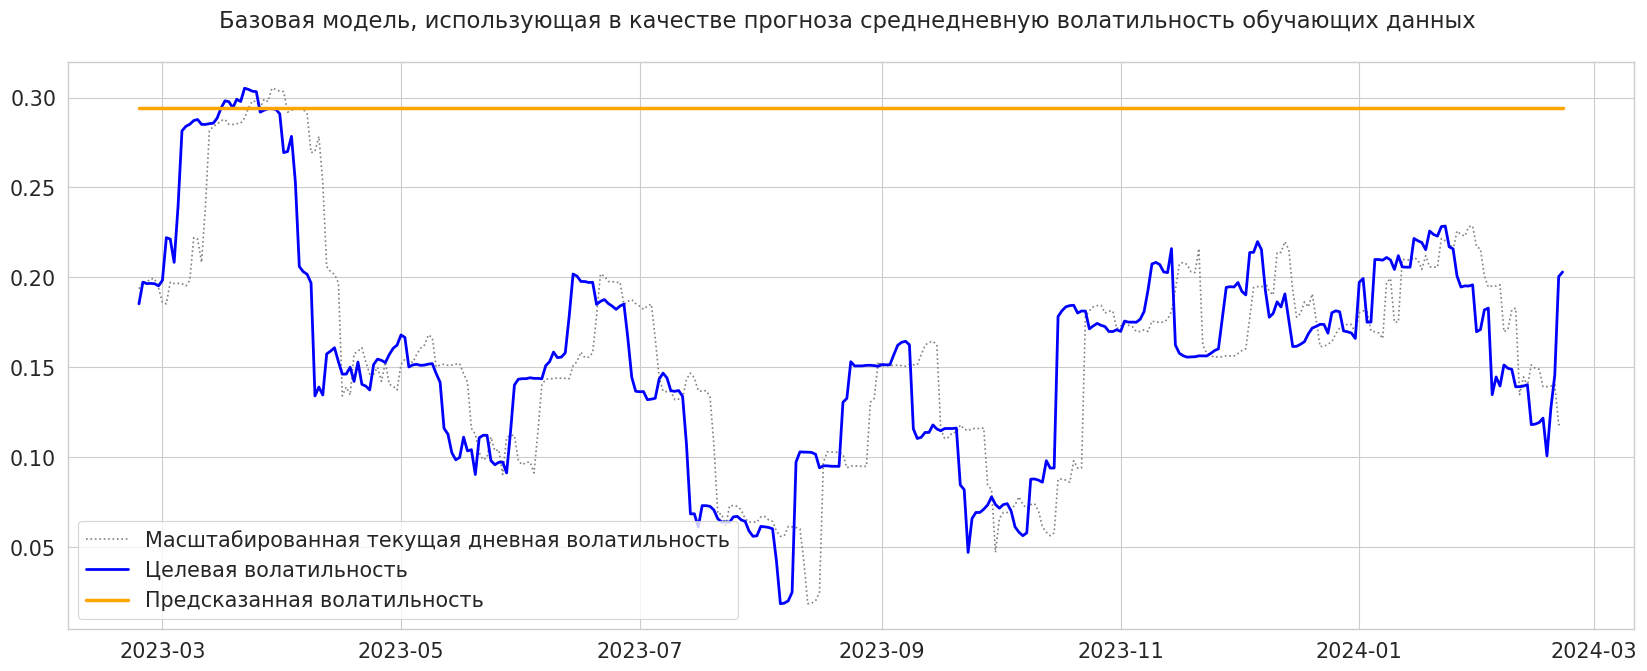

In [63]:
viz_model(y_val_scaled, baseline_preds,
          f"Базовая модель, использующая в качестве прогноза среднедневную волатильность обучающих данных")
plt.savefig(os.path.join('baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [64]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          2.108653         0.148776

### 2.2. Random Walk Naive Forecasting. Наивное прогнозирование. Случайное  блуждание


Общеизвестным фактом волатильности является то, что она имеет тенденцию быть **автокоррелированной** и **сгущаться** в
краткосрочной перспективе. Это свойство может быть использовано для реализации наивной модели, которая просто "предсказывает" будущую волатильность, используя то, какой была дневная волатильность непосредственно на предыдущем временном шаге.

В данном случае я буду использовать среднюю дневную волатильность за самый последний `INTERVAL_WINDOW` как
прогнозы на следующие 7 дней, которые по сути используют `vol_current` с шагом по времени t и
прогноз для `vol_future` на временном шаге t


In [65]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

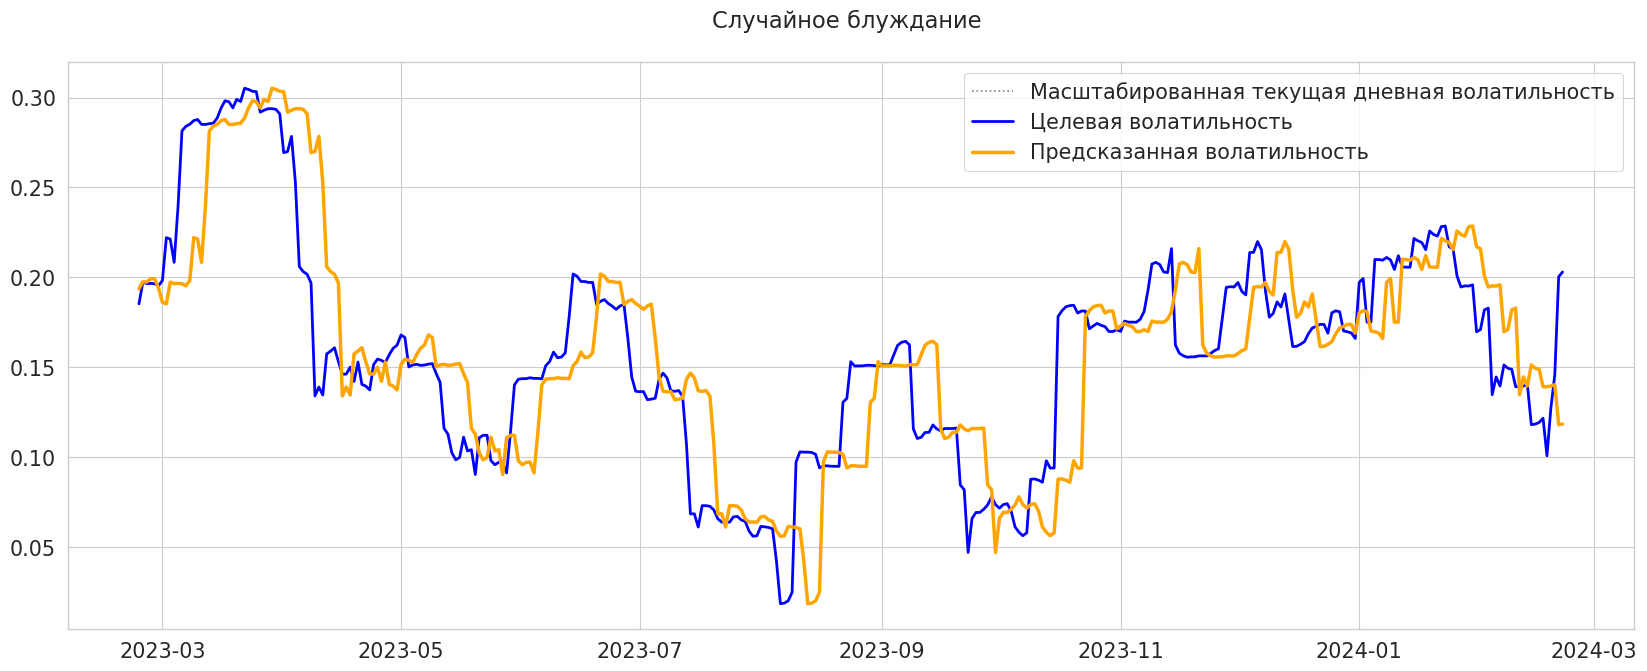

In [66]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Случайное блуждание')
plt.savefig(os.path.join('naive.jpg'),
            dpi=300, bbox_inches='tight')
plt.show();

In [67]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(round(y_val_scaled,3), round(random_walk_preds, 3),
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          2.108653         0.148776
1  Random Walk Naive Forecasting          0.352299         0.036363

In [68]:
round(random_walk_preds,3)

Date
2023-02-23 00:00:00+00:00    0.194
2023-02-24 00:00:00+00:00    0.197
2023-02-25 00:00:00+00:00    0.197
2023-02-26 00:00:00+00:00    0.199
2023-02-27 00:00:00+00:00    0.199
                             ...  
2024-02-18 00:00:00+00:00    0.139
2024-02-19 00:00:00+00:00    0.140
2024-02-20 00:00:00+00:00    0.140
2024-02-21 00:00:00+00:00    0.118
2024-02-22 00:00:00+00:00    0.118
Length: 365, dtype: float64


Таким образом, оба показателя ошибок снизились на приличную величину.

## 3. GARCH Models

(Reference: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)




GARCH  **Generalized Autoregressive Conditional Heteroskedasticity** расшифровывается как обобщенная авторегрессионная условная гетероскедастичность, которая является расширением модели ARCH (Авторегрессионная условная гетероскедастичность).

GARCH включает термины lag variance с lag residual errors от процесса усреднения и является традиционным эконометрическим подходом к прогнозированию волатильности финансовых временных рядов.

Математически GARCH можно представить следующим образом:


\begin{align*}
\sigma_{t}^2 = \omega + \sum_{i}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align*}

в котором $\sigma_{t}^2$ это дисперсия с шагом `t` и $\epsilon_{t-i}^2$ это остатки в модели с шагом  `t-1`

GARCH(1,1)  математическое уравнение для него таково:

\begin{align*}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align*}

где $\alpha$, $\beta$ и $\omega$ суммириуются и составляют 1, и $\omega$ это долгосрочная дисперсия.


(Reference: **Positional Option Trading** - Euan Sinclair)

GARCH обычно рассматривается как значительное улучшение по сравнению с наивным предсказанием, что будущая волатильность
будет похожа на прошлую, но некоторые эксперты в области волатильности также считают, что его значение как предиктора сильно переоценено. Модели GARCH отражают основные характеристики волатильности:
волатильность завтрашнего дня будет близка к сегодняшней (**кластеризация**), а волатильность в долгосрочной перспективе
вероятно будет означать **Возврат к среднему значению** (то есть она будет близка к тому, какой
была историческая долгосрочная средняя).

### 3.1. Basic GARCH

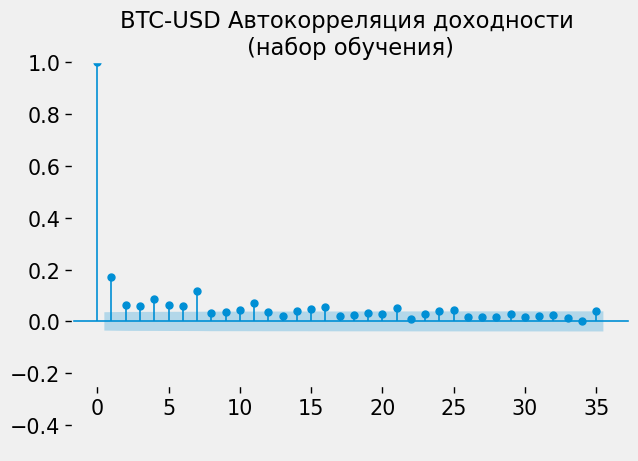

In [69]:

# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
fig, ax = plt.subplots()
plot_acf(r_train**2, ax=ax, title=f'{tckr.upper()} Автокорреляция доходности \n(набор обучения)')

# Adjust the position of the x-axis
ax.spines['bottom'].set_position(('data', -0.25))

# Adjust the y-axis limits to give space for the new x-axis position
ax.set_ylim(-0.5, 1.0)

plt.show()

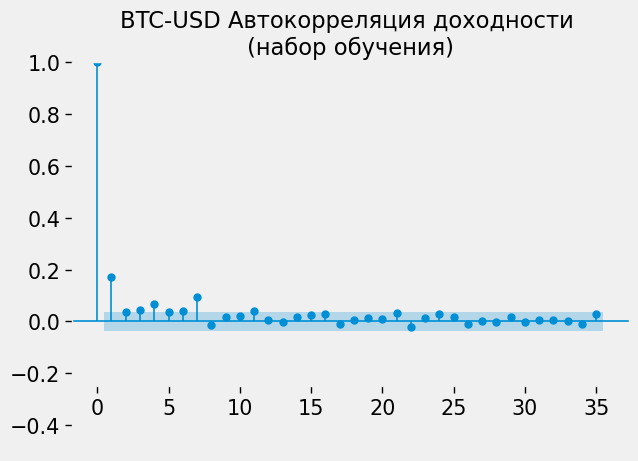

In [70]:

# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
fig, ax = plt.subplots()
plot_pacf(r_train**2, ax=ax, title=f'{tckr.upper()} Автокорреляция доходности \n(набор обучения)')

# Adjust the position of the x-axis
ax.spines['bottom'].set_position(('data', -0.25))

# Adjust the y-axis limits to give space for the new x-axis position
ax.set_ylim(-0.5, 1.0)

plt.show()


Графики автокорреляции, указывают на то, что существует значимая корреляция между значениями доходности за прошлые периоды до 7-го шага назад, а более ранние значения не кажутся слишком значительными.

In [71]:
from arch import arch_model



 Выставим значения p и q, равные 1, чтобы посмотреть, какие результаты  коэффициентов оно даст и проверим стат. значимость (при условии p-значения  `P > |t|`   меньше  0,05)




In [72]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)
# ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, power=2)
# forecaster.fit(y)

gm_1 = arch_model( r_train,mean='AR', lags =1, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                           AR - GARCH Model Results                           
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -8165.18
Distribution:                  Normal   AIC:                           16340.4
Method:            Maximum Likelihood   BIC:                           16370.5
                                        No. Observations:                 3050
Date:                Fri, Jul 19 2024   Df Residuals:                     3048
Time:                        11:23:23   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.2088  5.754e-02      3.629  2.843



Все коэффициенты выглядят статистически значимыми.

После подгонки к обучающим данным (процент доходности) прогноз модели GARCH содержит оцененный атрибут условной волатильности для обучающей части временного ряда. Я собираюсь преобразовать масштаб для массива данных условной волатильности обучающей выборки, а затем построить график, чтобы сравнить его с рассчитанной выше реализованной волатильностью (также масштабированной)  
`x_train_scaled`.

In [73]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [74]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [75]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

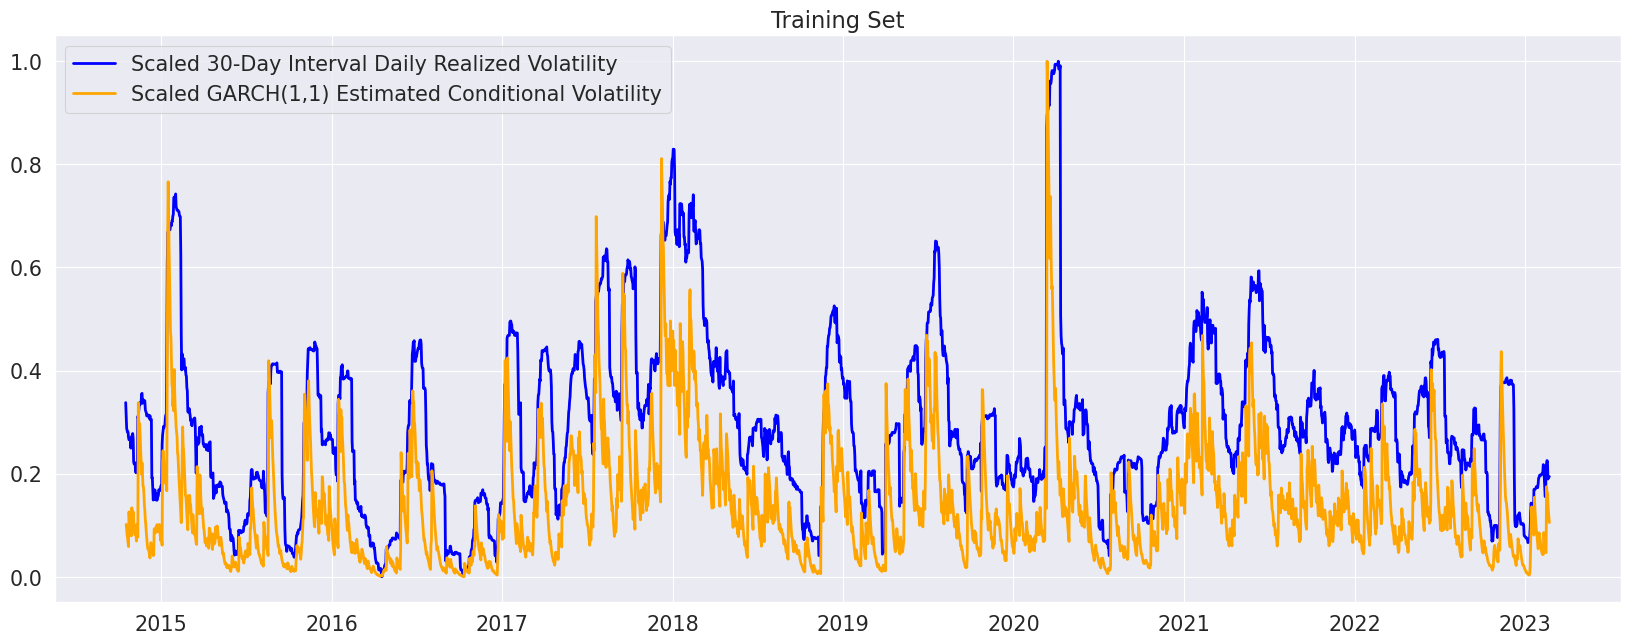

In [76]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')


#### 3.1.1. Analytical-based Forecasting

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

Прогнозы волатильности, полученные на основе моделей GARCH с использованием процентной доходности в качестве входных данных, имеют иной масштаб по сравнению с волатильностью, рассчитанной на основе логарифмической доходности. Поэтому я собираюсь нормализовать прогнозируемую волатильность на основе результатов модели conditional_volatility на обучающих данных и только сравнить масштабированные версии волатильностей в наборе валидации.

In [77]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index



# ARCH(mean='AR', lags=1, vol='GARCH', p=1, q=1, power=2)
# forecaster.fit(y)


# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA


    model = arch_model(train,  vol='GARCH',
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [78]:
val_idx

DatetimeIndex(['2023-02-23 00:00:00+00:00', '2023-02-24 00:00:00+00:00',
               '2023-02-25 00:00:00+00:00', '2023-02-26 00:00:00+00:00',
               '2023-02-27 00:00:00+00:00', '2023-02-28 00:00:00+00:00',
               '2023-03-01 00:00:00+00:00', '2023-03-02 00:00:00+00:00',
               '2023-03-03 00:00:00+00:00', '2023-03-04 00:00:00+00:00',
               ...
               '2024-02-13 00:00:00+00:00', '2024-02-14 00:00:00+00:00',
               '2024-02-15 00:00:00+00:00', '2024-02-16 00:00:00+00:00',
               '2024-02-17 00:00:00+00:00', '2024-02-18 00:00:00+00:00',
               '2024-02-19 00:00:00+00:00', '2024-02-20 00:00:00+00:00',
               '2024-02-21 00:00:00+00:00', '2024-02-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=365, freq=None)

In [79]:
gm_1_preds

Date
2023-02-23 00:00:00+00:00    3.214697
2023-02-24 00:00:00+00:00    3.288413
2023-02-25 00:00:00+00:00    3.167973
2023-02-26 00:00:00+00:00    3.098333
2023-02-27 00:00:00+00:00    3.002992
                               ...   
2024-02-18 00:00:00+00:00    2.729974
2024-02-19 00:00:00+00:00    2.679394
2024-02-20 00:00:00+00:00    2.632511
2024-02-21 00:00:00+00:00    2.602755
2024-02-22 00:00:00+00:00    2.585529
Length: 365, dtype: float64

In [80]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

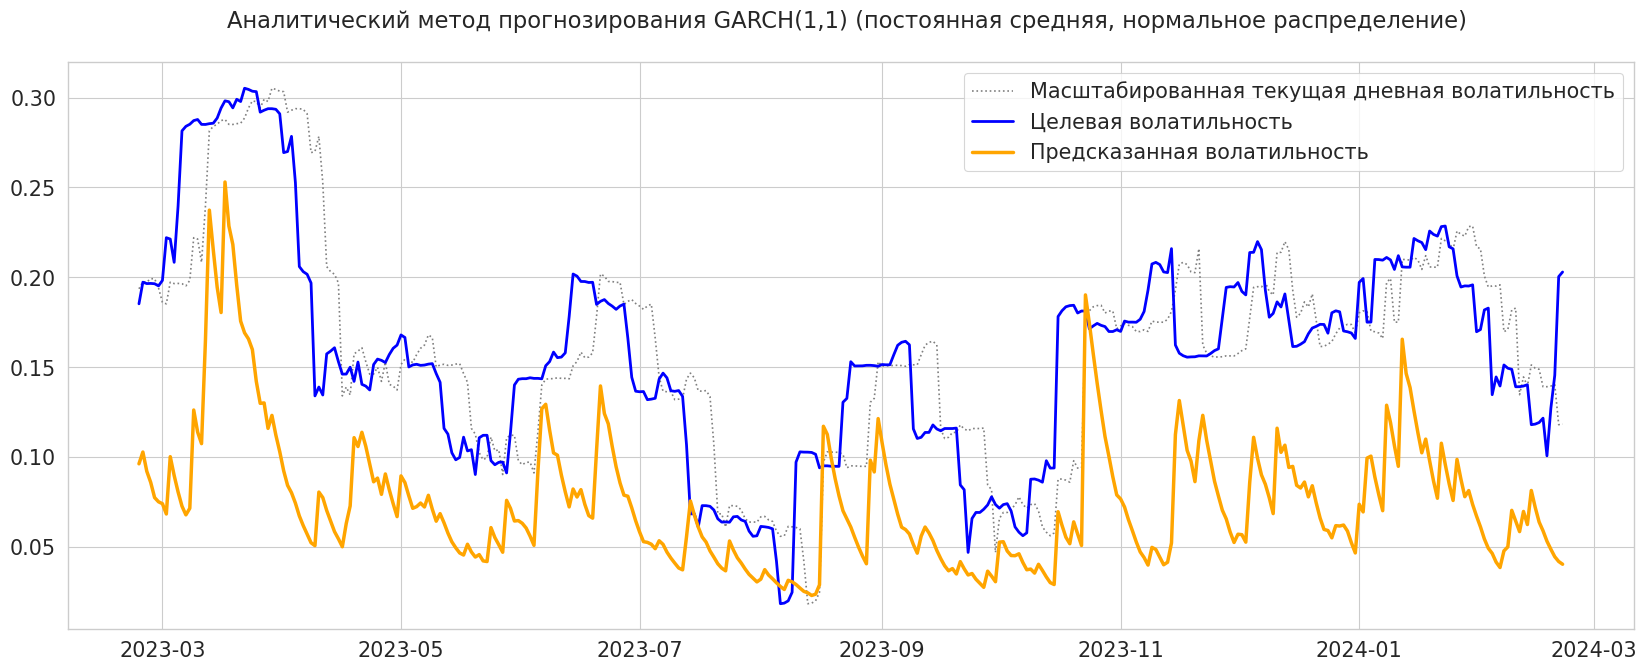

In [81]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled,
          'Аналитический метод прогнозирования GARCH(1,1) (постоянная средняя, нормальное распределение)')


Таким образом, прогнозирование на 7-дневный период все еще отстает от целевых значений.
Прогнозируемая волатильность GARCH, по-видимому, ниже (после нормализации).

In [82]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          2.108653         0.148776
1           Random Walk Naive Forecasting          0.352299         0.036363
2  GARCH(1,1), Constant Mean, Normal Dist          0.539417         0.094430


Затем я бы проверил предполагаемые остатки от этой первой модели GARCH.

In [83]:
result_1.resid

Date
2014-10-17 00:00:00+00:00         NaN
2014-10-18 00:00:00+00:00    1.796260
2014-10-19 00:00:00+00:00   -0.675416
2014-10-20 00:00:00+00:00   -1.933335
2014-10-21 00:00:00+00:00    0.724064
                               ...   
2023-02-18 00:00:00+00:00    0.134632
2023-02-19 00:00:00+00:00   -1.478898
2023-02-20 00:00:00+00:00    1.841335
2023-02-21 00:00:00+00:00   -1.772519
2023-02-22 00:00:00+00:00   -1.235750
Name: resid, Length: 3051, dtype: float64

In [84]:
result_1.conditional_volatility

Date
2014-10-17 00:00:00+00:00         NaN
2014-10-18 00:00:00+00:00    3.271910
2014-10-19 00:00:00+00:00    3.176579
2014-10-20 00:00:00+00:00    3.039958
2014-10-21 00:00:00+00:00    2.986643
                               ...   
2023-02-18 00:00:00+00:00    3.965409
2023-02-19 00:00:00+00:00    3.732194
2023-02-20 00:00:00+00:00    3.560719
2023-02-21 00:00:00+00:00    3.430846
2023-02-22 00:00:00+00:00    3.313137
Name: cond_vol, Length: 3051, dtype: float64

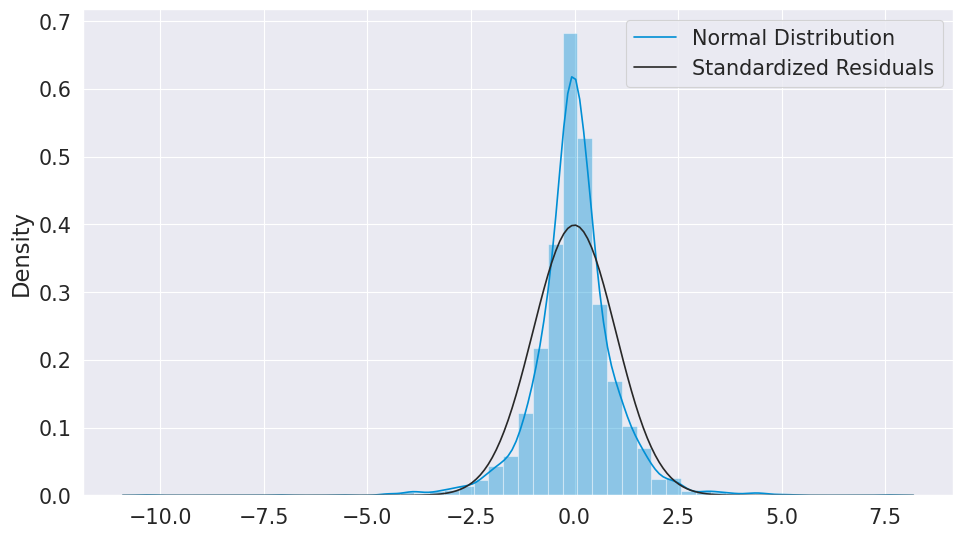

In [85]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

график стандартизированных остатков

(Reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)





По умолчанию базовый GARCH основан на некоторых предположениях о том, что остатки и средняя доходность распределены нормально.
Однако чаще всего данные финансовых временных рядов не соответствуют нормальному распределению, и более вероятно, что будут наблюдаться экстремальные положительные и отрицательные значения, которые далеки от среднего значения.

К счастью, есть определенные параметры, которые можно указать в arch_model, чтобы сделать ее более репрезентативной для реальных финансовых данных:
- `'dist'` может быть установлен `t` для T-распределения Стьюдента  или skewt для искаженного T-распределения Стьюдента (T-распределение Стьюдента также симметрично и имеет колоколообразную форму, как нормальное распределение; однако оно имеет более высокий пик и более толстые хвосты, что позволяет большему количеству значений находиться дальше от среднего значения).



### 3.2. Модель GARCH с асимметричными реакциями на шоки


Базовая модель GARCH предполагает, что позитивные и негативные новости оказывают одинаковое влияние на волатильность.
Однако на самом деле воздействие обычно асимметрично, и негативные воздействия, как правило, влияют на волатильность больше
, чем положительные.

В семействе GARCH есть еще один член, который объясняет асимметричную реакцию на шоки, называемый GJR-GARCH (сокращение от Glosten-Jagannathan-Runkle GARCH).

Дополнительные исходные данные могут быть использованы для построения других моделей. В этом случае, установив параметр `o`= 1, что означает, что модель будет включать одно запаздывание асимметричного шока, который преобразует модель GARCH в модель GJR-GARCH с динамикой дисперсии.

In [86]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train,mean='ARX', lags=1, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                               AR - GJR-GARCH Model Results                              
Dep. Variable:                           returns   R-squared:                      -0.000
Mean Model:                                   AR   Adj. R-squared:                 -0.001
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7753.28
Distribution:      Standardized Skew Student's t   AIC:                           15522.6
Method:                       Maximum Likelihood   BIC:                           15570.7
                                                   No. Observations:                 3050
Date:                           Fri, Jul 19 2024   Df Residuals:                     3048
Time:                                   11:23:38   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------



Логарифмическая вероятность Log-likelihood немного увеличилась. Давайте посмотрим, как выглядит условная волатильность

In [87]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

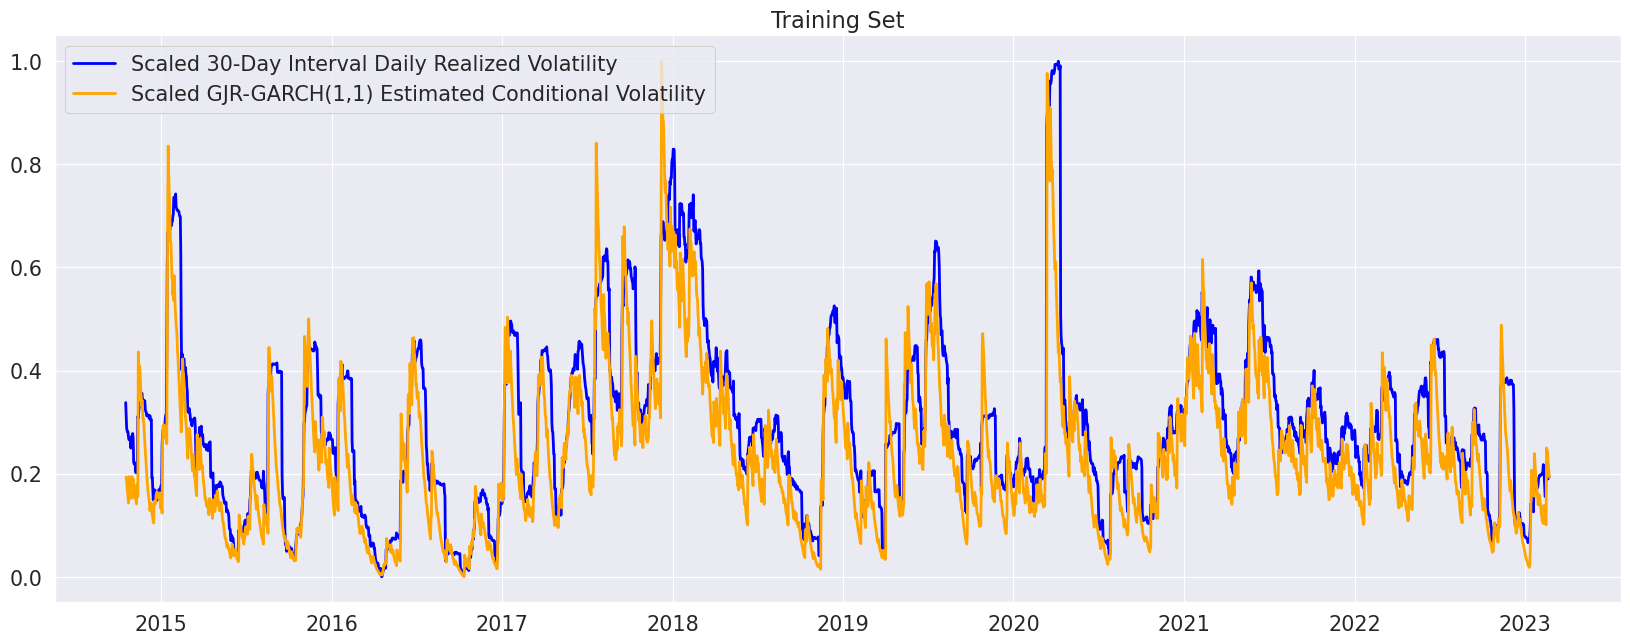

In [88]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [89]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [90]:
gjr_1_preds

0
Date                               
2023-02-23 00:00:00+00:00  3.076899
2023-02-24 00:00:00+00:00  3.107850
2023-02-25 00:00:00+00:00  2.975825
2023-02-26 00:00:00+00:00  2.895541
2023-02-27 00:00:00+00:00  2.777290
...                             ...
2024-02-18 00:00:00+00:00  2.414835
2024-02-19 00:00:00+00:00  2.342593
2024-02-20 00:00:00+00:00  2.278027
2024-02-21 00:00:00+00:00  2.222222
2024-02-22 00:00:00+00:00  2.178474

[365 rows x 1 columns]

In [91]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

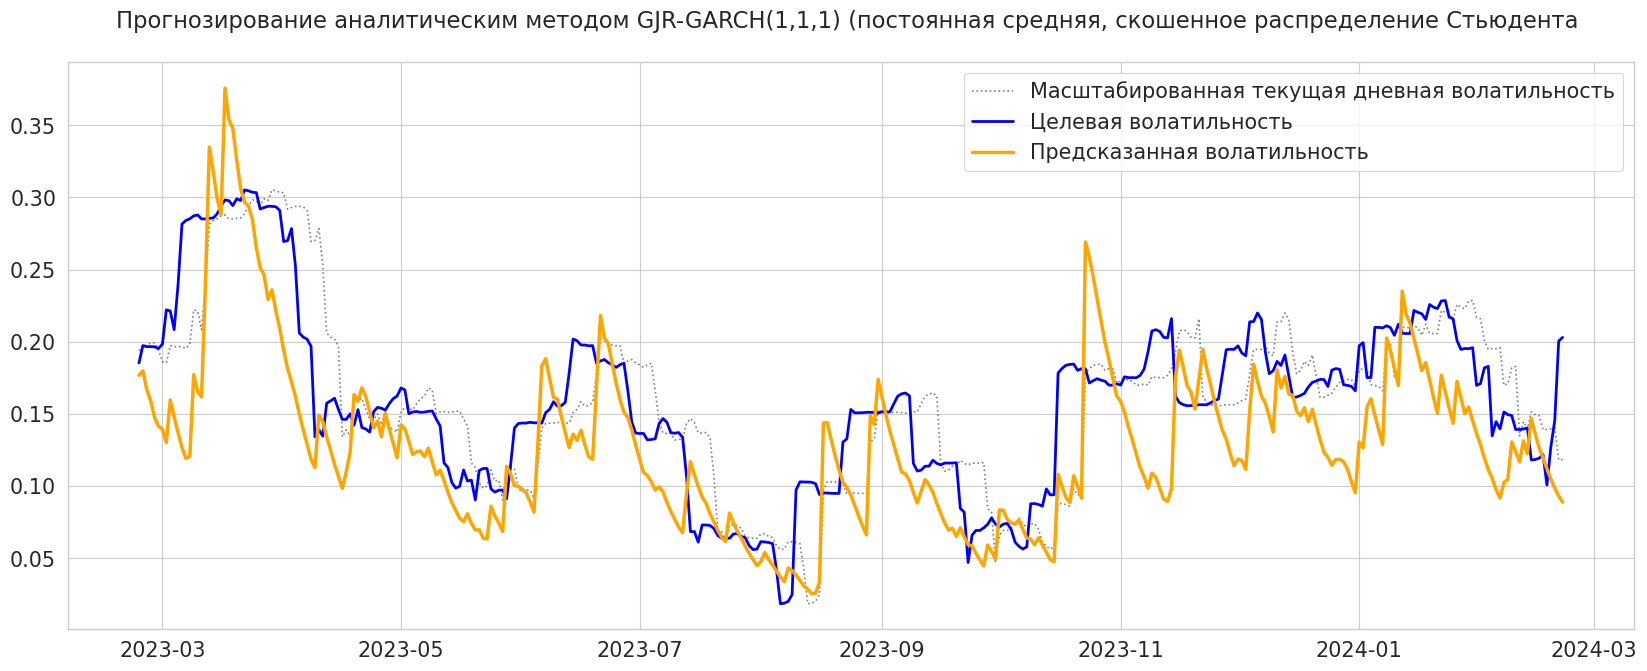

In [92]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled,
            "Прогнозирование аналитическим методом GJR-GARCH(1,1,1) (постоянная средняя, скошенное распределение Стьюдента")

In [93]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.108653   
1                           Random Walk Naive Forecasting          0.352299   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.539417   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.305346   

   Validation RMSE  
0         0.148776  
1         0.036363  
2         0.094430  
3         0.048995


По сравнению с GARCH (1,1) с настройкой нормального распределения, GJR-GARCH прогнозы с учетом скошенного распределения T- Стьюдента значительно продвинулись вперед и сократили разрыв между целевыми значениями и прогнозами модели. Это также нашло отражение в улучшении как RMSPE, так и RMSE.



### 3.3. TARCH

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)



В семействе GARCH есть еще TARCH **Threshold Autoregressive Conditional Heteroskedasticity** , что является сокращением от  Пороговой авторегрессионной условной гетероскедастичности (и также известный как ZARCH). TARCH моделирует волатильность, используя абсолютные значения (вместо квадратов). Для этой модели используется значение  `power=1.0`  . Кроме того, асимметричное воздействие также включено в структуру GARCH за счет использования фиктивной переменной

Процесс волатильности в модели TARCH(1,1) задается следующим образом:


\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

In [94]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7755.23
Distribution:      Standardized Skew Student's t   AIC:                           15524.5
Method:                       Maximum Likelihood   BIC:                           15566.6
                                                   No. Observations:                 3051
Date:                           Fri, Jul 19 2024   Df Residuals:                     3050
Time:                                   11:24:30   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------




Log-likelihood и AIC / BIC очень похожи на модель GJR-GARCH. Далее я проверю предполагаемую условную волатильность по сравнению с масштабированной `vol_current`.

In [95]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

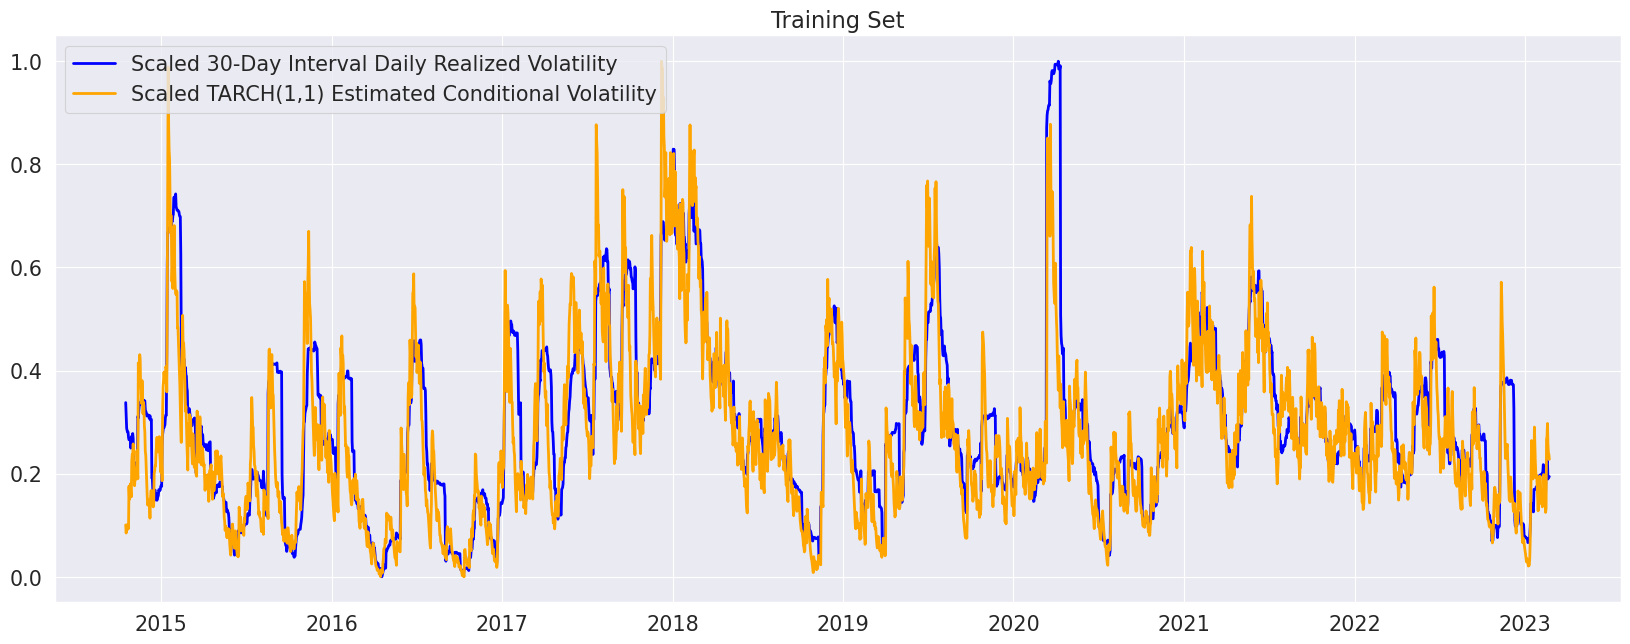

In [96]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

#### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

Модели TARCH не содержат прогнозов в закрытой форме (аналитических) для горизонтов больше 1, поэтому требуется моделирование или bootstrapping .

Прогнозы на основе Bootstrap практически идентичны прогнозам на основе моделирования, за исключением того, что значения, используемые для моделирования процесса, вычисляются на основе исторических данных, а не с использованием предполагаемых распределений остатков.

In [97]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [98]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

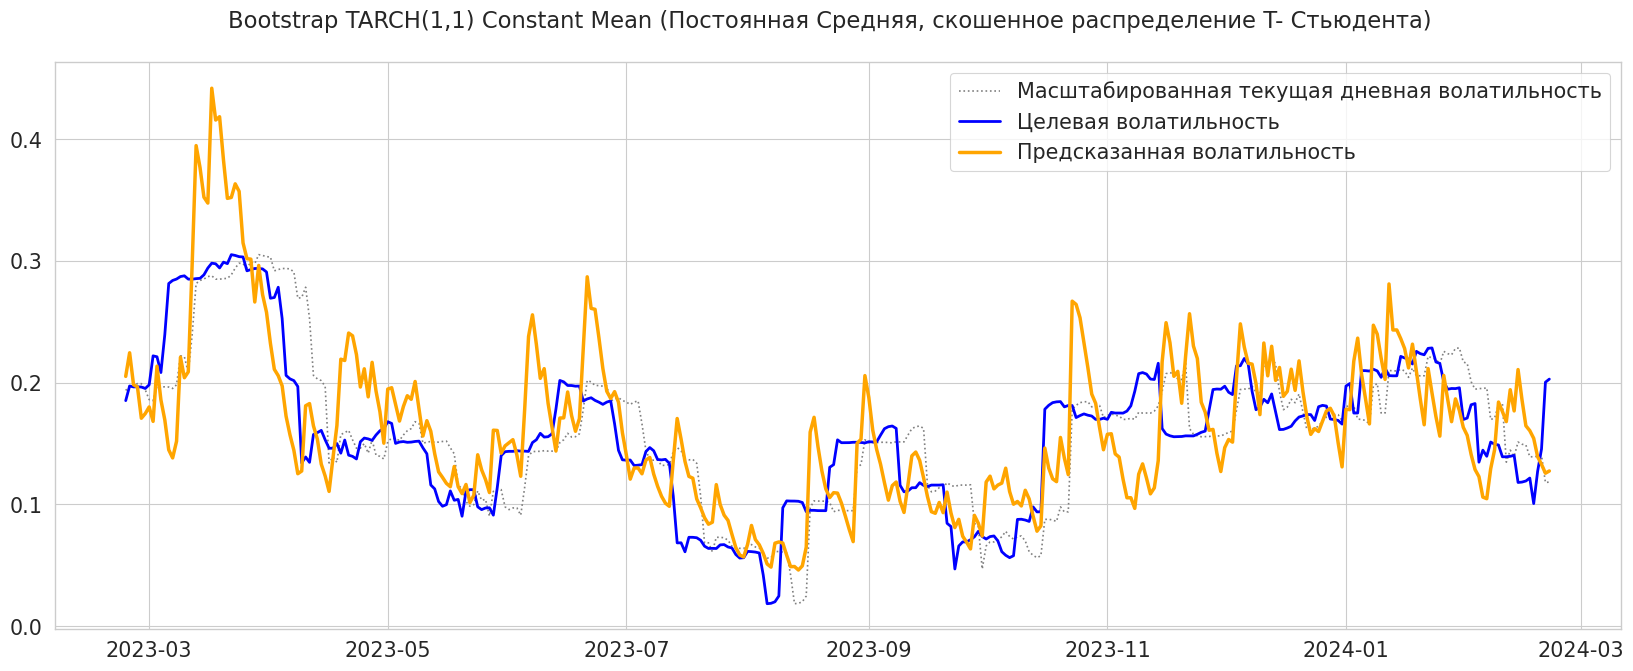

In [99]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled,
          "Bootstrap TARCH(1,1) Constant Mean (Постоянная Средняя, скошенное распределение T- Стьюдента) ")

In [100]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled,
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.108653   
1                           Random Walk Naive Forecasting          0.352299   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.539417   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.305346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.386430   

   Validation RMSE  
0         0.148776  
1         0.036363  
2         0.094430  
3         0.048995  
4         0.046375


Bootstrap TARCH (1,1) показал результаты хуже, чем GJR-GARCH

## 4. Нейронные сети

Хотя GARCH остается стандартом прогнозирования волатильности в традиционных финансовых учреждениях, в последние годы все большее число профессионалов и исследователей обращаются к машинному обучению, особенно к нейронным сетям, для получения информации о финансовых рынках.

(Reference: **Positional Option Trading** - Euan Sinclair)

Теория трейдеров о том, что рынок по своей сути эффективен (Efficient Market Hypothesis), утверждает, что цены акций отражают всю информацию и постоянно опережать рынок в целом невозможно. Чем эффективнее рынок, тем более случайными и непредсказуемыми будут доходы, и, следовательно, идеально эффективный рынок будет совершенно непредсказуемым.

Есть и другие аргументы против EMH, и один из наиболее заметных основан на поведенческих финансах: по сравнению с историей человечества, насчитывающей 200 000 лет, рынок не существует так долго. Например, опционы на акции торгуются только на ликвидном, прозрачном рынке с момента открытия Чикагской биржи опционов (Chicago Board Options Exchange) в 1973 году; а средний срок службы S&P 500 составляет около 20 лет. Это означает, что некоторые психологические тенденции людей имеют за собой 200 000
лет существования, и что многие движения рынков, которые были вызваны поведением участников, скорее всего, повторятся позже. Следовательно, рыночная система не может быть полностью случайной, она должна иметь какие-то закономерности.
Эти модели чрезвычайно сложно использовать из-за множества факторов, которые взаимодействуют и управляют рынком.

Было бы интересно посмотреть, как работают нейронные сети по сравнению с традиционными моделями GARCH





In [101]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal



Для нейронных сетей вместо того, чтобы сразу загружать все доступные данные, я буду использовать **sliding lookback window**. Я использую значение шага, равное 1, чтобы убедиться, что я получу все доступные комбинации входных и выходных данных, поскольку
2500 точек данных на самом деле не так уж много, чтобы сэкономить.

In [102]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [103]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

Для генерации прогнозов с использованием нейронных сетей будем использовать концепцию скользящего окна:
для генерации будущих прогнозов для временного шага t мне нужно будет вернуться назад во времени и вычислить последний n_past  (с шагом по времени t - n_past + 1 до t включительно).
Вот почему форма входных данных в эти нейронные сети должна быть **`[batch_size, n_past, 1]`**.


сравнение показателей RMSE и MSE

Среднеквадратичная ошибка (MSE) измеряет величину ошибки в статистических моделях. Она оценивает разницу в среднеквадратическую  разницу между наблюдаемыми и прогнозируемыми значениями. Если модель не содержит ошибок, MSE равен нулю. По мере увеличения ошибки модели увеличивается ее значение. Среднеквадратичная ошибка также известна как среднеквадратичное отклонение (MSD).

MSE Formula


 **особенности показателя MSE**

 Поскольку в нем используются квадратные единицы измерения, а не естественные единицы измерения данных,
 Возведение разностей в квадрат устраняет отрицательные значения разностей и гарантирует, что среднеквадратичная ошибка всегда будет больше или равна нулю (однако, интерпретация менее интуитивна).
 Кроме того, возведение в квадрат увеличивает влияние больших ошибок. Эти вычисления непропорционально сильно влияют на большие ошибки, а не на меньшие. Это свойство важно, если вы хотите, чтобы в вашей модели были меньшие ошибки.


**RMSE** используется в той же единице измерения, что и зависимая переменная, что делает его более интерпретируемым, чем MSE. Он сочетает в себе преимущества как MSE (чувствительность к большим ошибкам), так и MAE (нечувствительность к выбросам). Обычно используется, когда величина ошибок важна, а распределение данных приблизительно нормальное.

In [104]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [105]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [106]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

Epoch относится к одному полному прохождению всего набора обучающих данных через алгоритм обучения. Другими словами, когда все образцы данных подвергаются воздействию нейронной сети для изучения шаблонов, одна эпоха считается завершенной.

Количество эпох — это гиперпараметр , который определяет, сколько раз алгоритм обучения будет работать со всем набором обучающих данных. Слишком мало эпох может привести к недостаточной подгонке модели, тогда как слишком большое количество эпох может привести к переобучению.

Epoch , Iterations и Batches

Batches: набор из N выборок из набора данных. Размер пакета — это гиперпараметр, определяющий количество выборок, которые необходимо обработать перед обновлением внутренних параметров модели.
Итерация: одно обновление параметров модели. Каждая итерация — это количество пакетов, необходимых для завершения одной эпохи.
Epoch: один полный цикл обработки данных обучения

Предположим, есть набор данных с 200 выборками, и мы выбираем Batch = 5 и  Epoch = 1000 .
Это означает, что набор данных будет разделен на 40 пакетов, в каждом из которых будет по пять выборок. Веса моделей будут обновляться после каждой партии из пяти образцов.
Это также означает, что в течение одной эпохи будет 40 партий или 40 обновлений модели.
За 1000 периодов модель будет подвергнута обработке или пройдет через весь набор данных 1000 раз. Это в общей сложности 40 000 пакетов в течение всего процесса обучения.



В течение каждой эпохи веса нейронной сети обновляются в попытке минимизировать функцию потерь , которая измеряет разницу между прогнозируемыми и истинными выходными данными. По мере увеличения количества эпох веса настраиваются, и в идеале точность модели повышается.




### 4.1. Базовые метрики нейронных сетей - Fully Connected Network**
По сути, это линейная регрессия.

(При обучении непосредственно с использованием scaled volatility приводит к `inf`, поэтому я буду придерживаться исходной волатильности и масштабировать прогнозы позже).

Я начну с использования lookback window `n_past` =  14,, а затем постепенно буду корректировать это значение на основе результатов моих моделей.


In [107]:
# TensorFlow and Keras to create a simple neural network model for time series forecasting.

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
#     This layer flattens the input shape, converting the input data from a 2D array (with shape [n_past, 1]) to a 1D array.
#     It is necessary because the neural network expects a 1D input.
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),
    # DENSE OUTPUT LAYER
#     чтобы создать полносвязные слои
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse',
              optimizer='adam',
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [108]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0,
#                       This parameter controls the verbosity mode during training. Setting it to 0 means silent mode
                      batch_size=batch_size,
                      shuffle=True)
# This parameter determines whether the training data should be shuffled at the beginning of each epoch. Shuffling helps prevent the model from memorizing the order of the training data and improves generalization.
# the fraction of the training data to use as validation data. 20% of the training data  for validation, and the remaining 80%  for training.
# Shuffle parameters produce a randomized set of values.

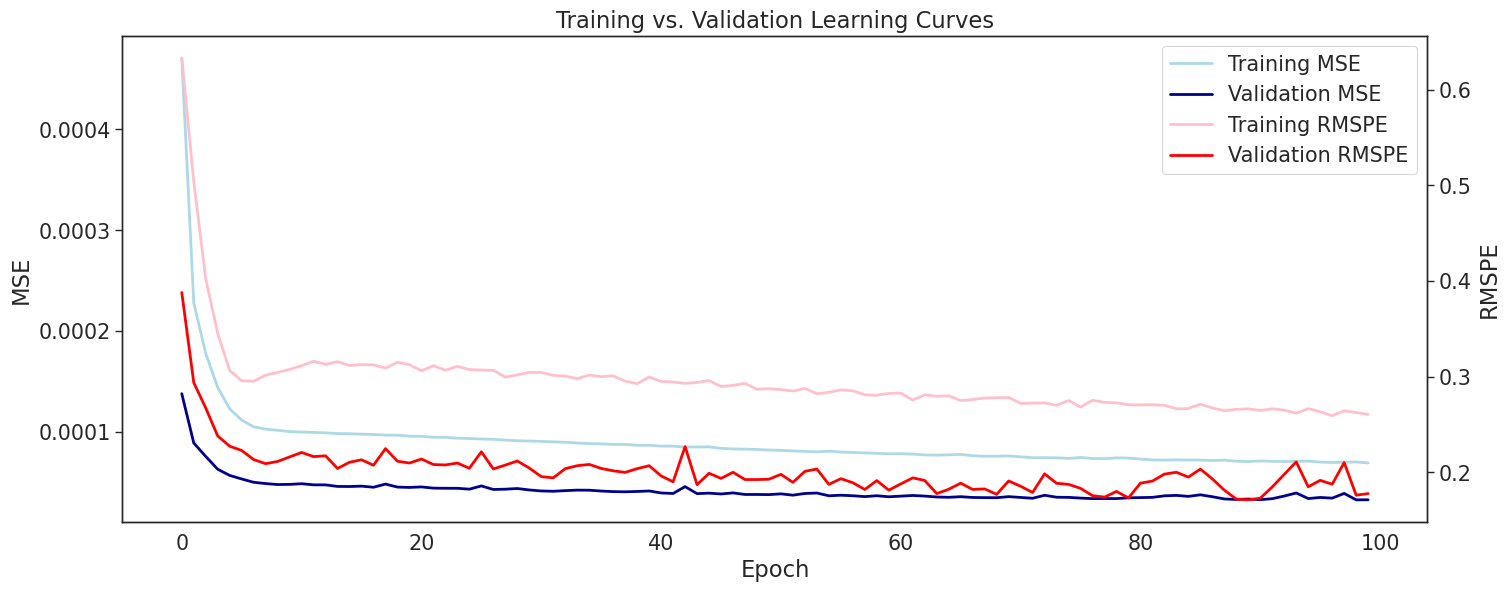

In [109]:
viz_train_val_metrics(snn_1_res)

In [110]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 1ms/step


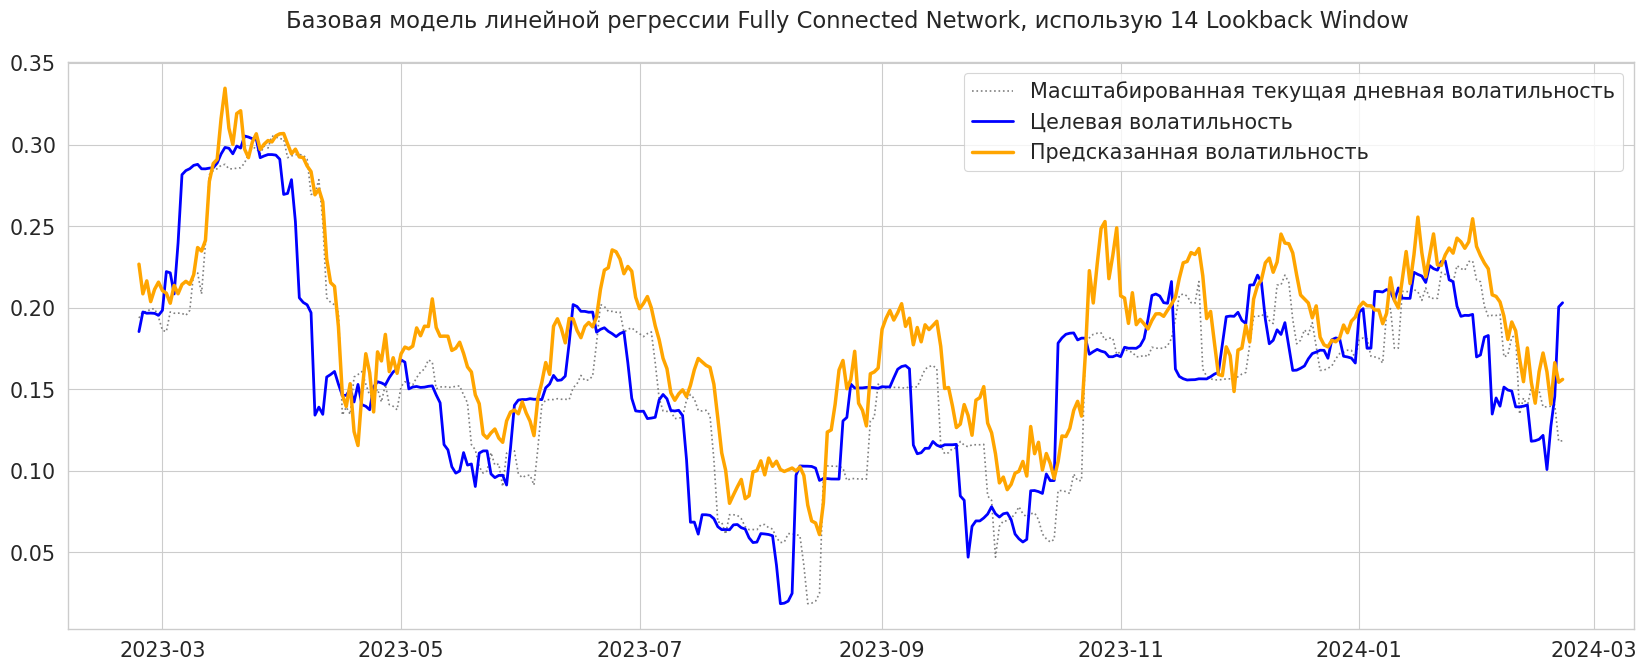

In [111]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
n_past = 14
viz_model(y_val_scaled, snn_1_preds_scaled,
          f"Базовая модель линейной регрессии Fully Connected Network, использую {n_past} Lookback Window")
plt.savefig(os.path.join( 'fully_connected_NN.png'),
            dpi=300, bbox_inches='tight')
plt.show();

По сравнению с  целевыми значениями , прогноз лучше отслеживает текущую линию волатильности


In [112]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.108653   
1                           Random Walk Naive Forecasting          0.352299   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.539417   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.305346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.386430   
5                 Simple LR Fully Connected NN, n_past=14          0.581856   

   Validation RMSE  
0         0.148776  
1         0.036363  
2         0.094430  
3         0.048995  
4         0.046375  
5         0.043657


Simple Fully Connected NN работает хуже, чем предыдущие модели. RMSPE после 100 эпох обучения и практически без настройки хуже, чем RMSPE модели TARCH (1,1)

### 4.2. Univariate Long Short-Term Memory (LSTM)**

(Reference: Geron (2019)

Существует класс нейронных сетей, называемых Рекуррентными нейронными сетями (RNN), которые могут "предсказывать будущее". RNN хорошо работает с данными временных рядов, такими как цены акций, и даже может обрабатывать предложения, документы в качестве входных данных. Другое применение RNN - в системах автономного вождения, где они используются для прогнозирования траектории движения автомобиля и помогают избежать аварий.

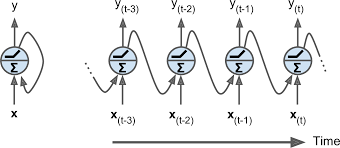




На каждом временном шаге t  рекуррентный нейрон получает входные данные $x_{t}$ ,  а также его собственный результат из предыдущего временного шага $y_{t-1}$. Поскольку выходной сигнал рекуррентного нейрона является функцией всех входных сигналов
с предыдущих временных шагов, он имеет форму памяти и способный сохранять некоторую информацию с течением времени.

Однако из-за некоторых преобразований, через которые проходят данные при перемещении вниз по RNN, некоторая информация теряется на каждом временном шаге, и для длинной последовательности состояние RNN не содержит практически никакой информации из первых входных данных.

**Long Short-Term Memory (LSTM)**  была предложена в 1997 году Зеппом Хохрайтером и Юргеном Шмидхубером. Ключевой частью LSTM является то, что сеть может узнавать, что важно и должно храниться в долгосрочном состоянии, а что можно игнорировать. LSTM выглядит очень похоже на обычную ячейку RNN, но ее состояние разделено на 2 вектора:
- $h_{t}$ -  для краткосрочного состояния
- $c_{t}$ - для долгосрочного состояния

LSTM - это черный ящик, и его можно использовать как базовую ячейку рекуррентной нейронной сети (RNN). Однако он, как правило, работает намного лучше, помогает быстрее сходиться при обучении, а также обнаруживать долгосрочные
зависимости в данных.

LSTM использует оптимизированную реализацию при работе на графическом процессоре,  почему лучше запускать эту вторую часть ноутбука в Google Colab.





Первая модель LSTM была бы очень простой, имея всего 1 скрытый слой LSTM из 20 единиц. Я использую стандартный `adam` оптимизатор здесь, и позже, при необходимости, поэкспериментирую с другими оптимизаторами.


In [113]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
#  LSTM layers are particularly useful for sequential data, such as time series where capturing long-term dependencies is important.
# (20): the number of units (or neurons) in the LSTM layer= a memory cell that can store information over time. More units allow the model to capture more complex patterns in the data.

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
    # the dense layer has only one unit = the output of this layer will be a single scalar value, which is typical for regression tasks where the model predicts a continuous output.
])


lstm_1.compile(loss='mse',
               optimizer="adam",
              #  used to update the model's weights during training in order to minimize the loss function.
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                # the filename where the model weights will be saved
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  # the number of epochs to wait before stopping the training if the monitored quantity does not improve.
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [114]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

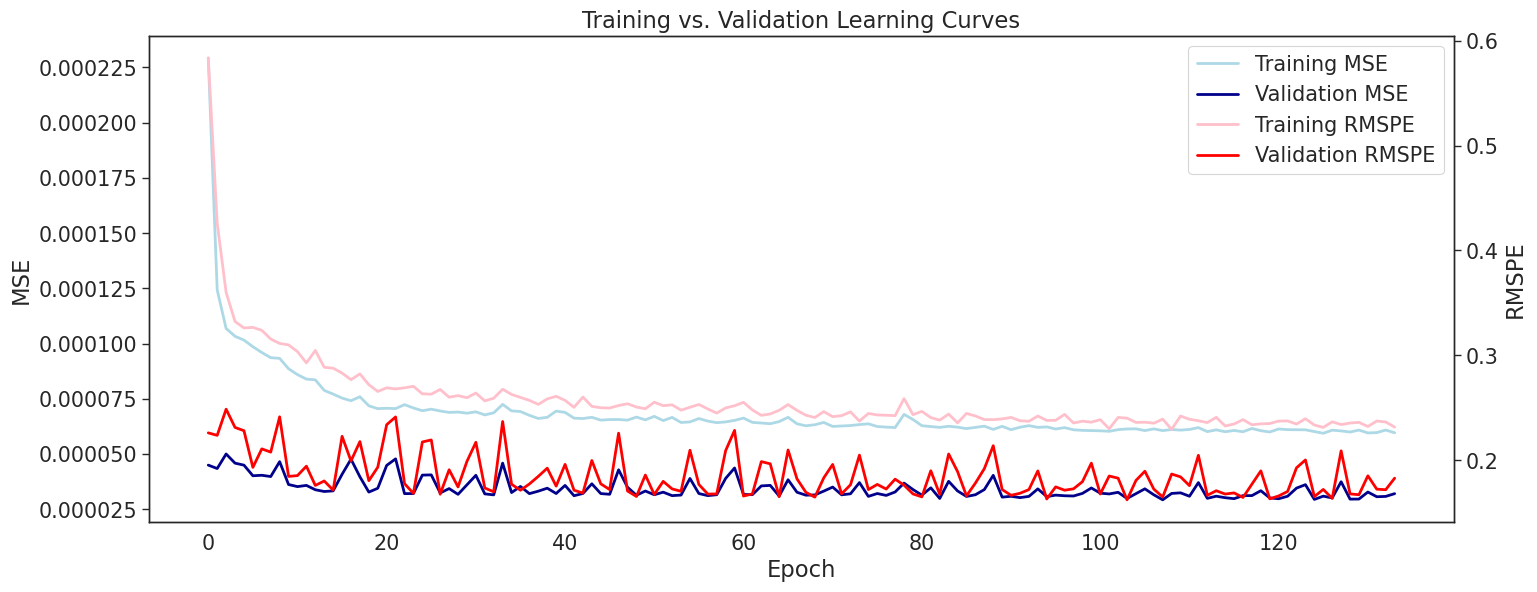

In [115]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)



 в целом все кривые, за исключением  MSE, выглядят довольно нестабильными.


In [116]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 0s 3ms/step


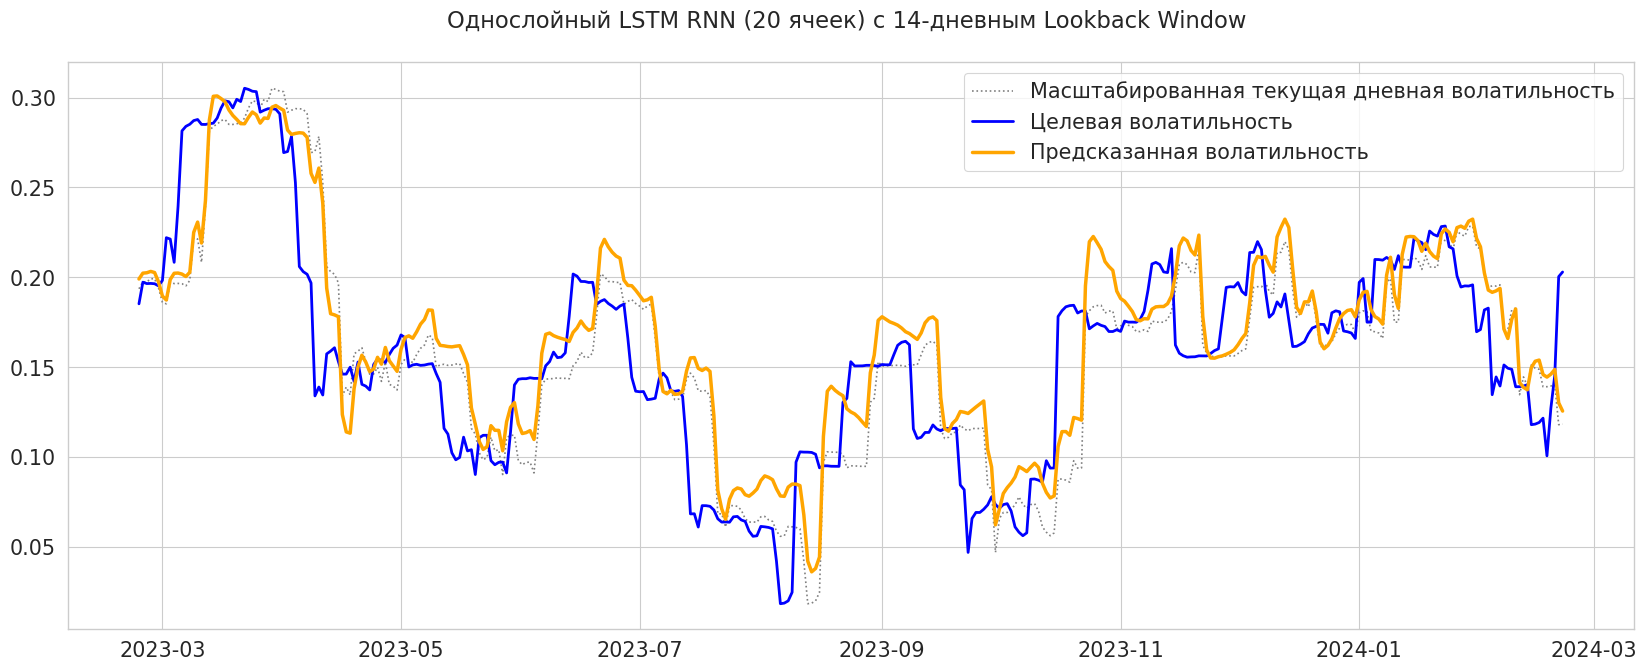

In [117]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET

viz_model(y_val_scaled, lstm_1_preds_scaled,
          f"Однослойный LSTM RNN (20 ячеек) с {n_past}-дневным Lookback Window")
plt.savefig(os.path.join('lstm_1.png'),
            dpi=300, bbox_inches='tight')
plt.show();



Опять же, предсказания отслеживают `vol_current` довольно хорошо, и линия прогнозирования сгладилась по сравнению с прогнозами fully connected NN (что означает, что он менее шумный), но он все еще также
отстает по сравнению с желаемой целью.


In [118]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.108653   
1                           Random Walk Naive Forecasting          0.352299   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.539417   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.305346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.386430   
5                 Simple LR Fully Connected NN, n_past=14          0.581856   
6                        LSTM 1 layer 20 units, n_past=14          0.449882   

   Validation RMSE  
0         0.148776  
1         0.036363  
2         0.094430  
3         0.048995  
4         0.046375  
5         0.043657  
6         0.035825



Простая одноуровневая LSTM  значительно лучше, чем предыдущая модель по показателю RMSPE, и на самом деле имеет более низкий RMSE, чем простая LR NN, описанная выше.

### 4.3. Одномерный двунаправленный LSTM Univariate Bidirectional LSTM


(Reference: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)



Дальнейшие исследования показывают, что существует  **Bidirectional LSTM** (Двунаправленное LSTM), которое потенциально могло бы быть лучше в этом случае, предоставляя дополнительный контекст моделям. Поскольку все временные интервалы входной последовательности уже доступны, двунаправленный LSTM может обучать 2 вместо 1 LSTM для одной и той же входной последовательности:

• первый на входах как есть

• второй на обратной копии входных данных


LSTM позволяет сохранять определенные исторические данные, поэтому я их расширю n_past до 1 месяца, а также увеличу количество скрытых слоев, чтобы увидеть, сможет ли модель лучше передавать определенные тенденции.



Слой Forward LSTM: Этот слой обрабатывает входную последовательность от начала до конца, улавливая зависимости от прошлого к будущему.

Обратный LSTM-слой: Этот слой обрабатывает входную последовательность в обратном порядке, улавливая зависимости от будущего к прошлому.


Основная идея использования двунаправленных LSTM заключается в том, чтобы позволить модели обращаться к прошлой и будущей информации при составлении прогнозов, тем самым улучшая ее способность улавливать временные зависимости в данных.

In [119]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1st BIDIRECTIONAL LSTM LAYER with 32 units (or neurons).
    #  The return_sequences=True parameter indicates that the LSTM layer should return the full sequence of outputs for each input sequence rather than just the last output.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19105 (74.63 KB)
Trainable params: 19105 (74.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [120]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

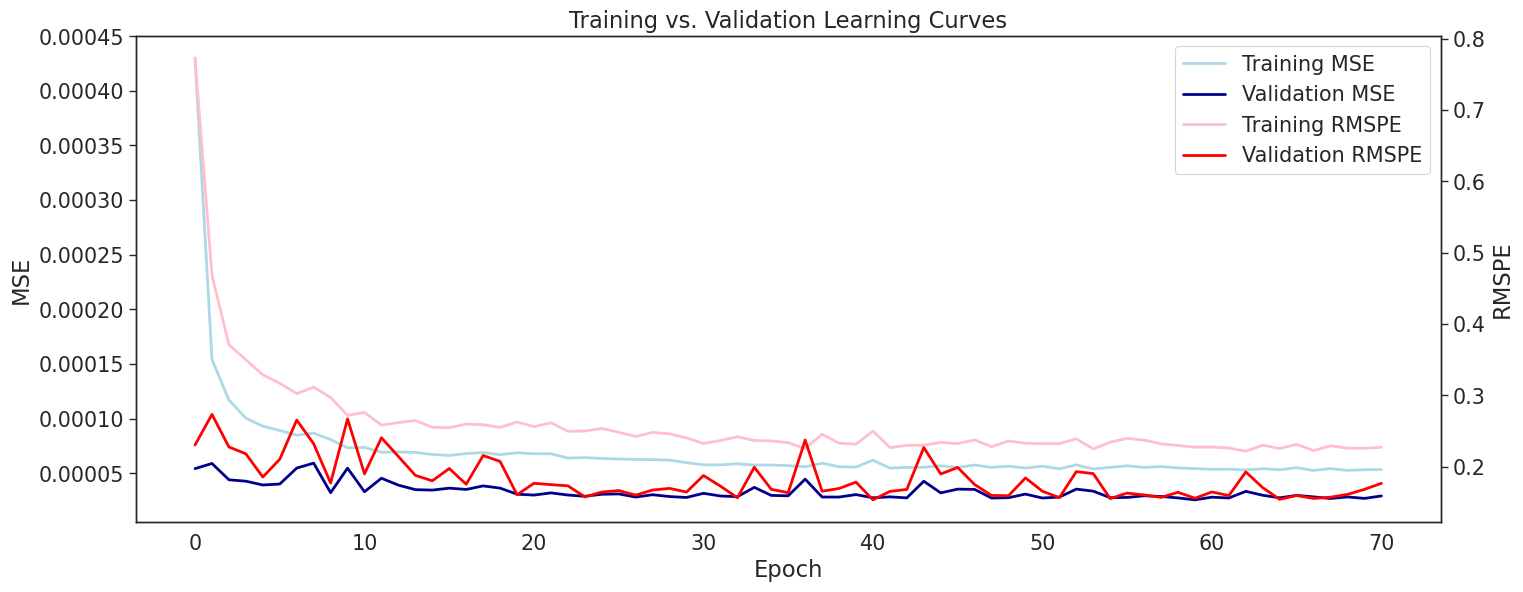

In [121]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [122]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 2s 9ms/step


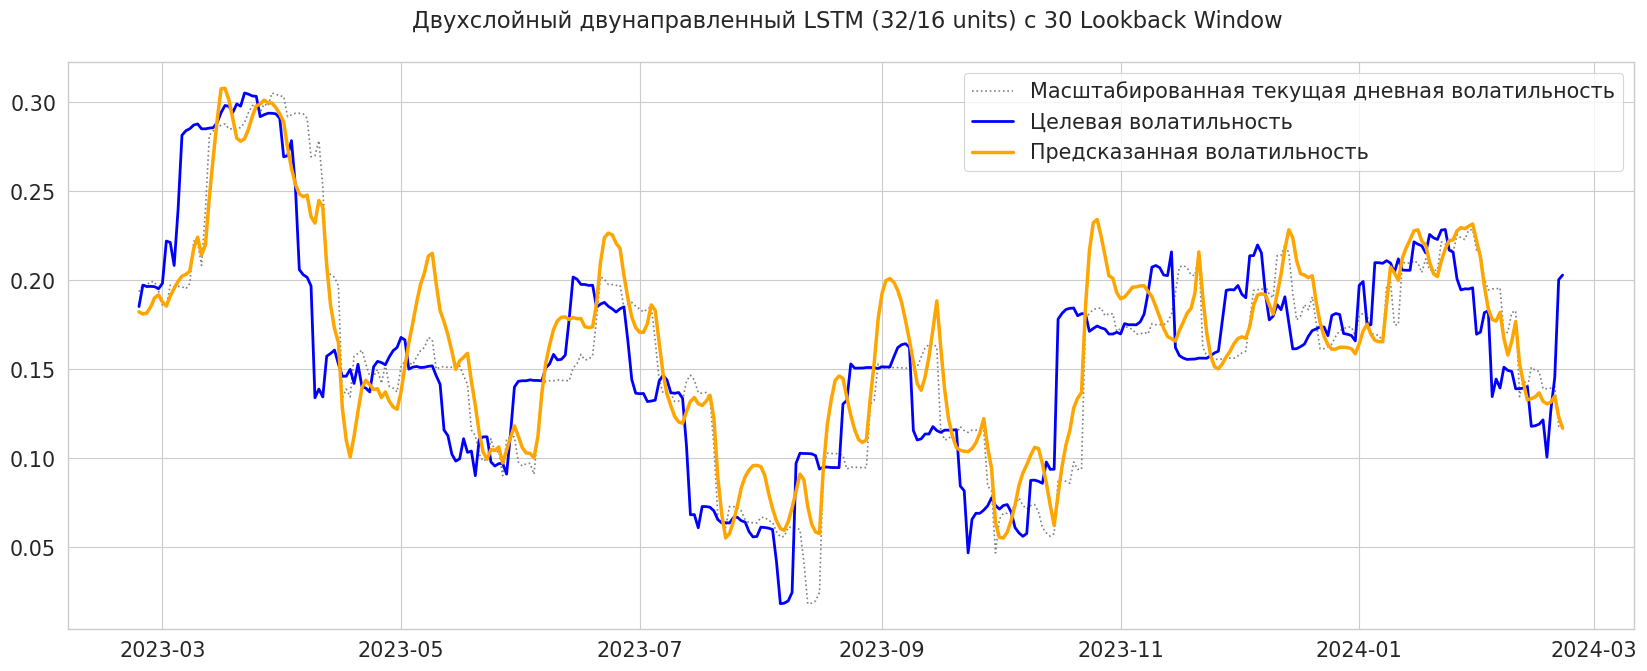

In [123]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled,
          f"Двухслойный двунаправленный LSTM (32/16 units) с {n_past} Lookback Window")
plt.savefig(os.path.join( 'lstm_2.png'),
            dpi=300, bbox_inches='tight')
plt.show();

In [124]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled,
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.108653   
1                           Random Walk Naive Forecasting          0.352299   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.539417   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.305346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.386430   
5                 Simple LR Fully Connected NN, n_past=14          0.581856   
6                        LSTM 1 layer 20 units, n_past=14          0.449882   
7         2 layers Bidirect LSTM (32/16 units), n_past=30          0.362675   

   Validation RMSE  
0         0.148776  
1         0.036363  
2         0.094430  
3         0.048995  
4         0.046375  
5         0.043657  
6         0.035825  
7         0.034445



2 Layered Bidirectional LSTM с окном анализа в 30 дней превзошел
модели GARCH.


4.4. Одномерный двунаправленный LSTM + 1D сверточный слой (слои) (Univariate Bidirectional LSTM + 1D Convolutional Layer(s) )
(Reference: Geron (2019))

1D convolutional layer перемещает несколько ядер по последовательности, создавая одномерную карту пространственных объектов для каждого ядра. Предполагается, что сверточные слои позволяют расширять lookback window и помогают модели выявлять тенденции к изменению стоимости из прошлого.

Функция активации - это математическая операция. Она вносит нелинейность в работу сети, позволяя ей изучать сложные закономерности и взаимосвязи в данных. Функции активации являются важнейшими компонентами нейронных сетей, поскольку они позволяют сети аппроксимировать и представлять нелинейные отношения между входными и выходными переменными.

роль функции активации: Внесение нелинейности: Без функций активации вся нейронная сеть фактически была бы линейным преобразованием входных данных, поскольку несколько линейных операций (например, умножение матрицы) были бы сложены вместе. Функции активации вносят нелинейные преобразования в выход каждого нейрона, позволяя сети обучаться и представлять сложные нелинейные отношения в данных.

ReLU (Rectified Linear Unit) - одна из наиболее часто используемых функций активации в глубоком обучении.

Вот почему ReLU широко используется:

Простота: ReLU эффективна с точки зрения вычислений и проста в реализации. Он просто заменяет отрицательные значения на ноль, оставляя положительные значения неизменными.

In [125]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()


# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER
    tf.keras.layers.Conv1D(
        # Each filter kernels is responsible for detecting specific patterns or features/A higher number of filters allow the layer to learn more diverse features but also increase the computational complexity.
        filters=32,
# kernel_size - width of the kernel (4 elements). During the convolution operation
        # (element-wise multiplication between the kernel and the overlapping region of the input data,
        # followed by summation of the products. This operation is applied iteratively across the entire input volume,
        # producing an output feature map that represents the presence of different features in the input data)
        kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2,
        # Strides determine how much the convolutional kernel shifts (or steps) across the input data at each iteration of the convolution operation.
                           padding="valid",
        # the output size is reduced compared to the input size
# padding is to preserve the spatial size of the input so that the output after applying filters (kernels) remains the same size, or to adjust it according to the desired output dimensions.
                           activation="relu",
                           input_shape=[None, 1]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 

In [126]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

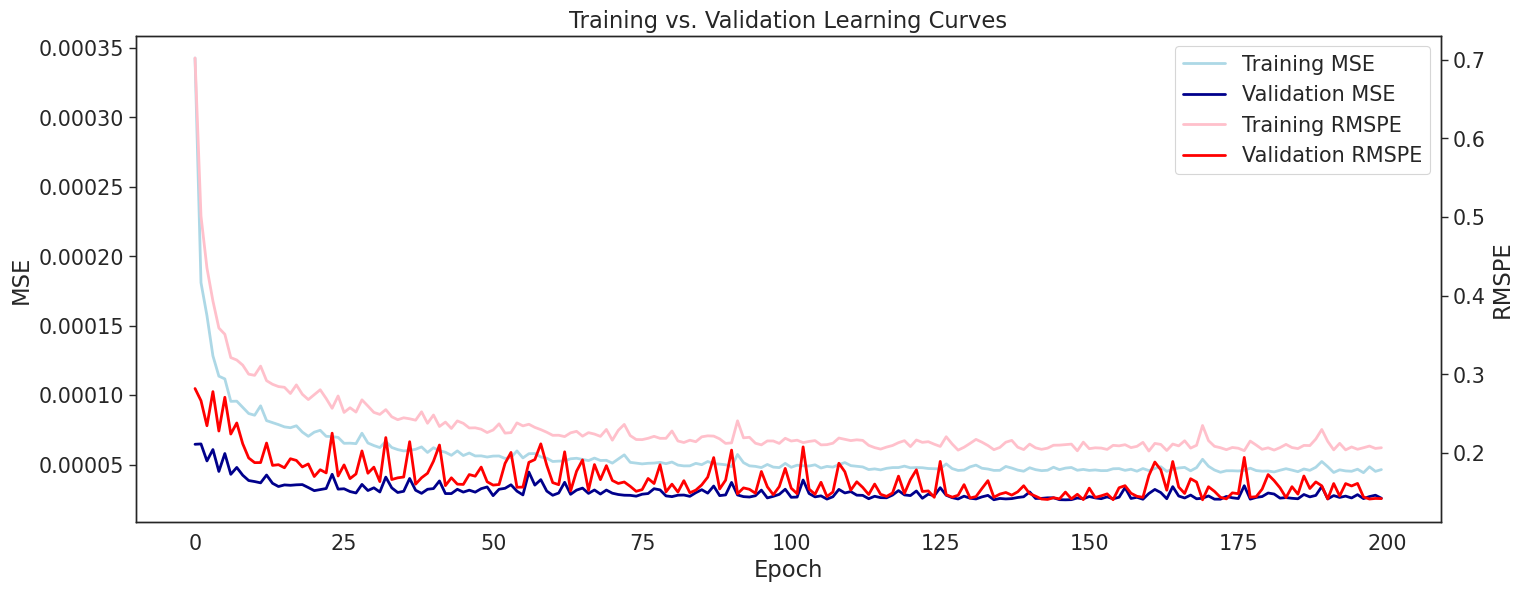

In [127]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [128]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 1s 6ms/step


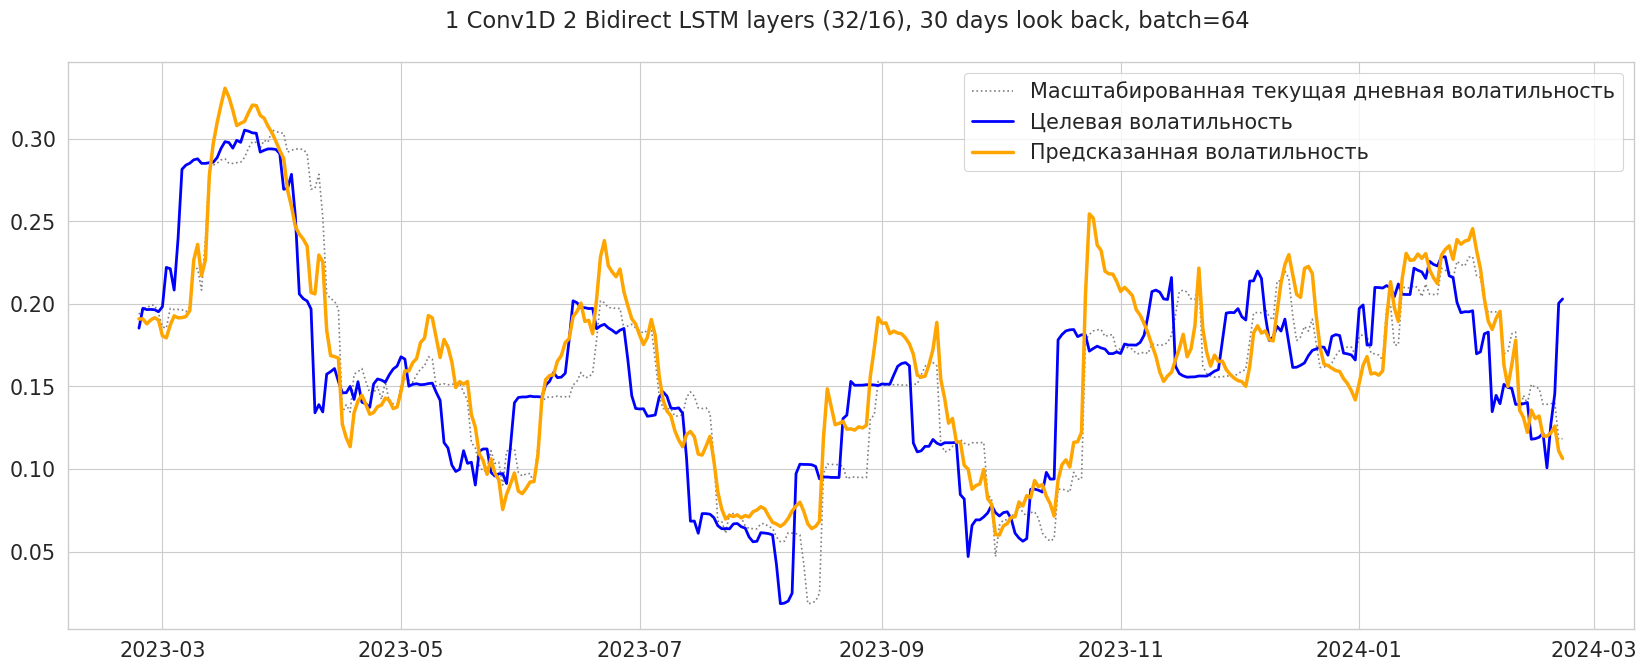

In [129]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled,
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.savefig(os.path.join('lstm_3.png'),
            dpi=300, bbox_inches='tight')
plt.show();

In [130]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled,
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                 Mean Baseline   
1                                 Random Walk Naive Forecasting   
2                        GARCH(1,1), Constant Mean, Normal Dist   
3        Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4               Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                       Simple LR Fully Connected NN, n_past=14   
6                              LSTM 1 layer 20 units, n_past=14   
7               2 layers Bidirect LSTM (32/16 units), n_past=30   
8  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          2.108653         0.148776  
1          0.352299         0.036363  
2          0.539417         0.094430  
3          0.305346         0.048995  
4          0.386430         0.046375  
5          0.581856         0.043657  
6          0.449882         0.035825  
7          0.362675         0.034445  
8          0.357957         0.034735

Cверточные слои показатели результат хуже чем, прошлая модель. производительность в некоторой степени ухудшилась.

4.6. Multivariate LSTM (Многомерная LSTM)

Пока я использую только простые одномерные входные данные для всех моих моделей, а для финансовых данных этого, вероятно, недостаточно. Не имеет значения, сколько нейронов или скрытых слоев используется, или насколько сложна архитектура модели, некачественные данные, скорее всего, не приведут к хорошим результатам.

В следующем разделе я попытаюсь создать многомерные нейронные сети, чтобы посмотреть, могут ли дополнительные функции помочь повысить производительность.



In [131]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                             Volume   returns  log_returns  vol_current  \
Date                                                                      
2014-10-17 00:00:00+00:00  13600700  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  11416800  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00   5914570 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16419000 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  14188900  0.948166     0.009437     0.034362   

                           vol_future  
Date                                   
2014-10-17 00:00:00+00:00    0.032900  
2014-10-18 00:00:00+00:00    0.033009  
2014-10-19 00:00:00+00:00    0.033083  
2014-10-20 00:00:00+00:00    0.033017  
2014-10-21 00:00:00+00:00    0.031334

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3446 entries, 2014-10-17 00:00:00+00:00 to 2024-03-23 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3446 non-null   float64
 1   High         3446 non-null   float64
 2   Low          3446 non-null   float64
 3   Close        3446 non-null   float64
 4   Volume       3446 non-null   int64  
 5   returns      3446 non-null   float64
 6   log_returns  3446 non-null   float64
 7   vol_current  3446 non-null   float64
 8   vol_future   3446 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 398.3 KB


In [133]:
df.describe()

Open          High           Low         Close        Volume  \
count   3446.000000   3446.000000   3446.000000   3446.000000  3.446000e+03   
mean   15591.110824  15957.005510  15201.996399  15608.317544  1.712396e+10   
std    17061.256341  17475.775387  16607.504172  17076.646476  1.929467e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%     1046.732452   1065.965027   1027.837494   1047.330017  2.437978e+08   
50%     8671.997559   8844.913574   8422.109863   8672.835449  1.277198e+10   
75%    26499.883301  26815.430176  26110.242676  26510.061035  2.743327e+10   
max    73079.375000  73750.070312  71334.093750  73083.500000  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3446.000000  3446.000000  3446.000000  3446.000000  
mean      0.217202     0.001486     0.034271     0.034287  
std       3.685412     0.037135     0.015829     0.015834  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.223070    -0.012306     0.023614     0.023614  
50%       0.146899     0.001468     0.031950     0.031950  
75%       1.710980     0.016965     0.042754     0.042835  
max      25.247169     0.225119     0.103878     0.103878

4.6.1. Настройка характеристик

Цены открытия / Максимума / Минимума / закрытия обычно очень похожи и сильно коррелируют друг с другом. Поэтому вместо того, чтобы хранить их все в наборе данных, я бы добавил еще 2 функции:

• Высокий-низкий спред - который представляет собой логарифм разницы между самой высокой и самой низкой ценами внутри дня в процентах от цены закрытия

• Спред открытия-закрытия - это разница между ценами закрытия и Открытия внутри дня в процентах от цены закрытия

и далее для объема: • Столбец Volume имеет очень большие значения, которые в миллиарды / миллионы раз больше, чем у других объектов. Поэтому я собираюсь получить np.log().

и убрать колонки Close, Open, High, Low.

In [134]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [135]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2014-10-17 00:00:00+00:00  16.425632  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  16.250597  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00  15.592929 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16.613950 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  16.467971  0.948166     0.009437     0.034362   

                           vol_future   HL_sprd   CO_sprd  
Date                                                       
2014-10-17 00:00:00+00:00    0.032900 -3.638567  0.002618  
2014-10-18 00:00:00+00:00    0.033009 -3.185630  0.019444  
2014-10-19 00:00:00+00:00    0.033083 -3.952483 -0.004365  
2014-10-20 00:00:00+00:00    0.033017 -3.476822 -0.016407  
2014-10-21 00:00:00+00:00    0.031334 -3.487953  0.010601

In [136]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

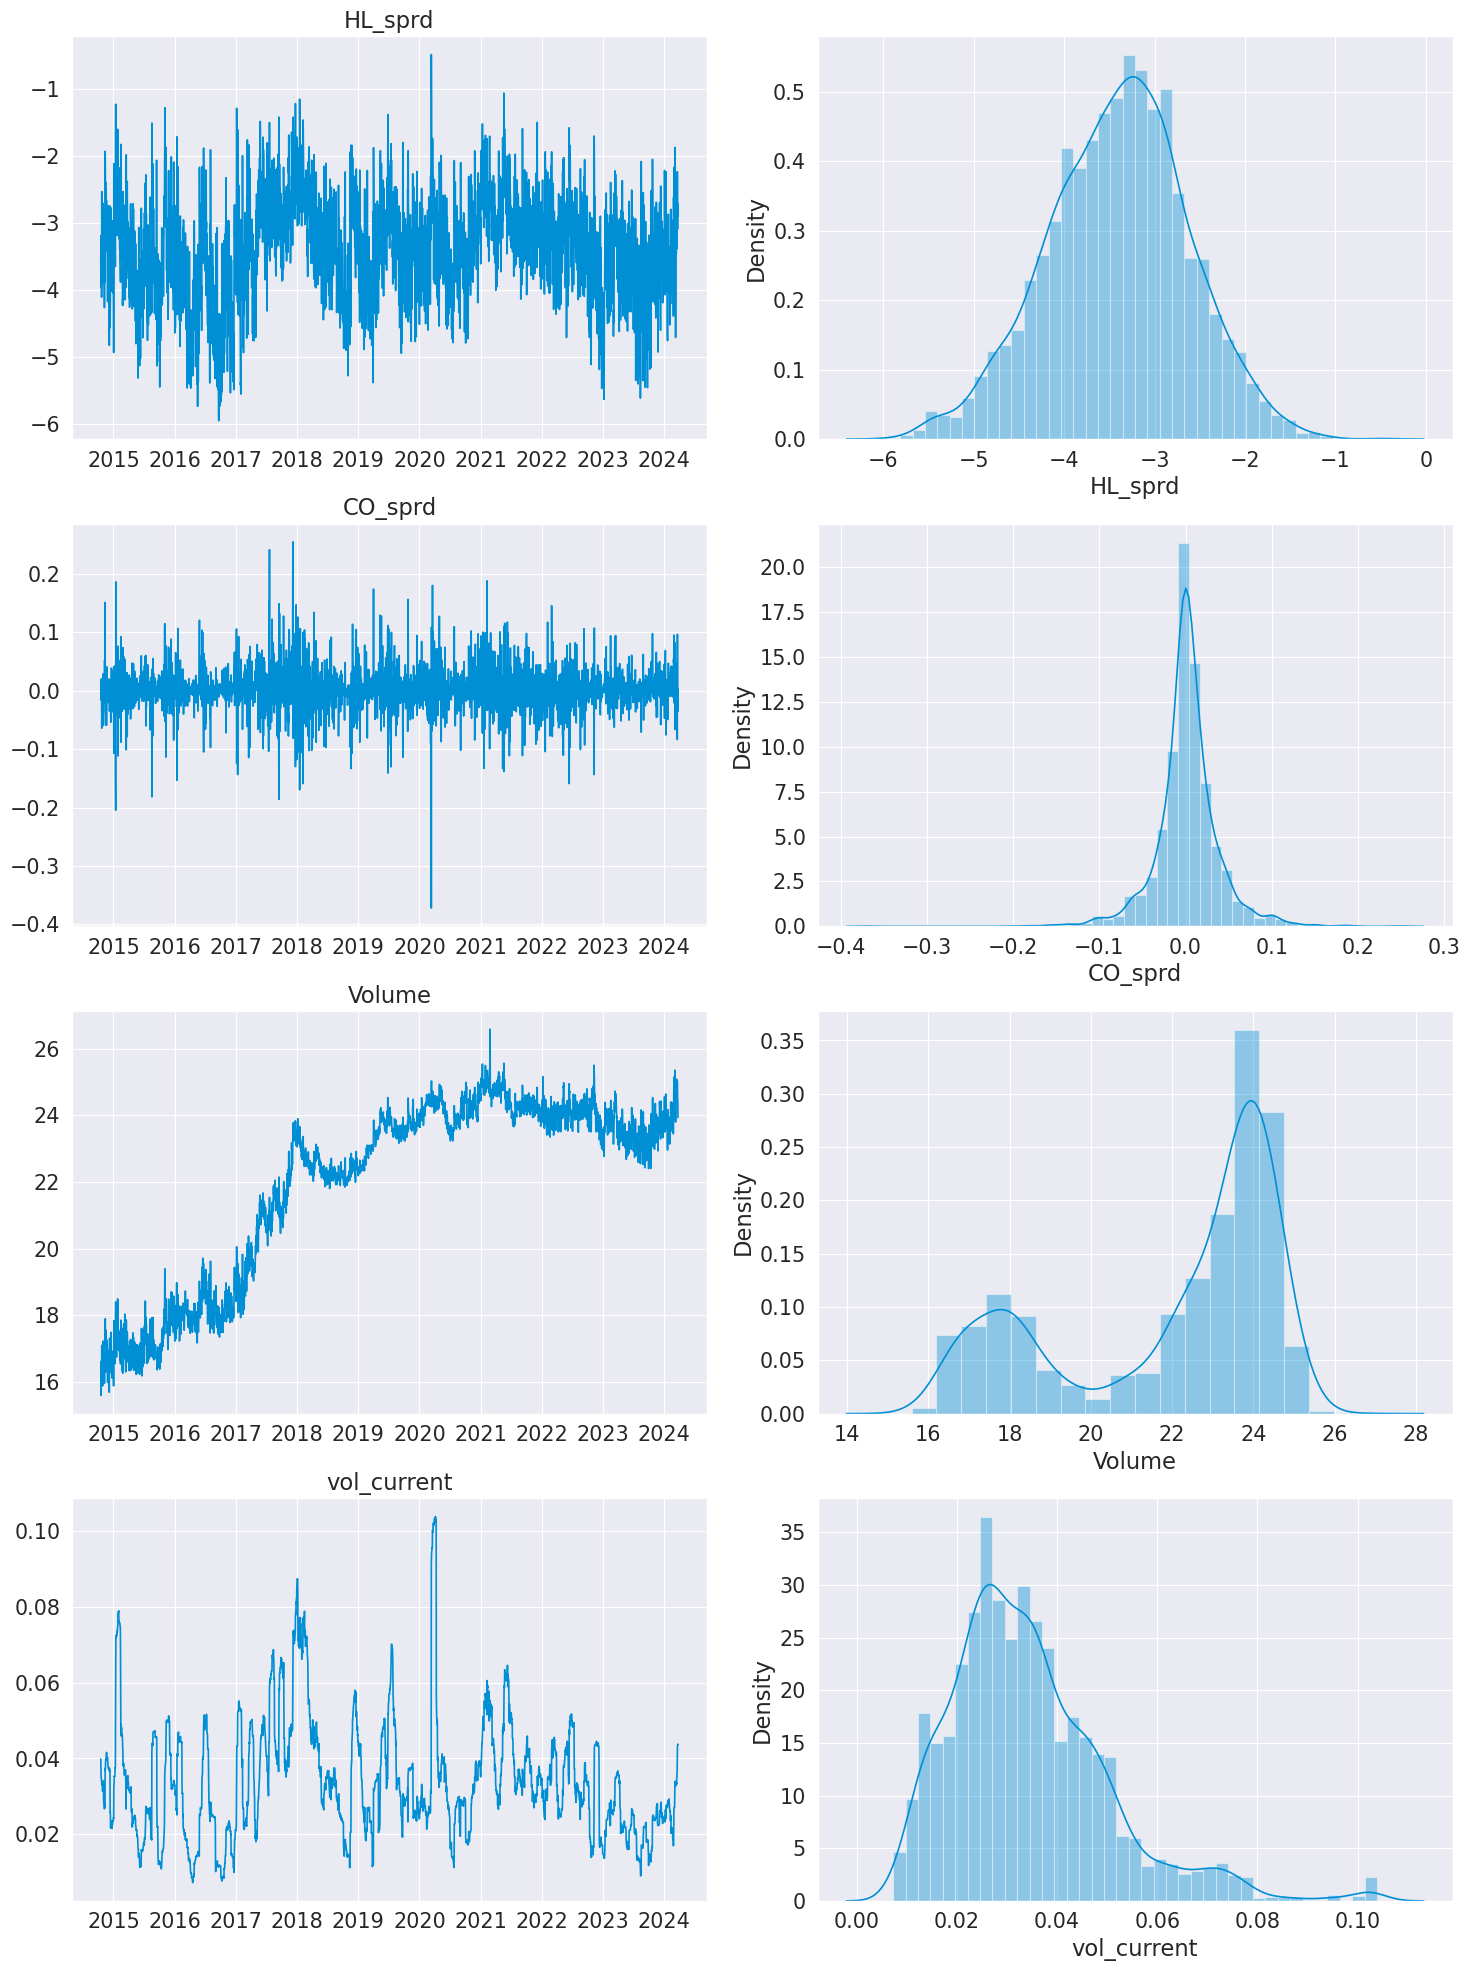

In [137]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    plt.savefig(os.path.join( 'features.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

Эти числовые характеристики необходимо будет нормализовать позже, поскольку в LSTM используются sigmoid и tanh активация функций, к которым очень чувствительна величина.

Поскольку vol_current уже является производным от log_returns , я не собираюсь включать log_returns в мою модель.

4.6.2. Input Reshaping

Изменение формы входных данных является основой этих многомерных LSTM. Вообще говоря, входные данные для LSTM должны иметь форму: [batch_size, n_past, входные данные] в котором:

• batch_size - количество точек данных в каждом пакете

• n_past - количество прошедших временных шагов, которые будут использоваться для прогнозирования (пока я буду использовать то же значение, что и выше).

• input_dims - количество входных объектов (в данном случае 4)

In [138]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [139]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [140]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3051 entries, 2014-10-17 00:00:00+00:00 to 2023-02-22 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3051 non-null   float64
 1   CO_sprd      3051 non-null   float64
 2   Volume       3051 non-null   float64
 3   vol_current  3051 non-null   float64
dtypes: float64(4)
memory usage: 119.2 KB


In [142]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3446 entries, 2014-10-17 00:00:00+00:00 to 2024-03-23 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3446 non-null   float64
 1   CO_sprd      3446 non-null   float64
 2   Volume       3446 non-null   float64
 3   vol_current  3446 non-null   float64
dtypes: float64(4)
memory usage: 263.6 KB


In [143]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

Моя первая многомерная модель LSTM была бы относительно простой с 2 скрытыми слоями двунаправленного LSTM (очень похоже на одномерную структуру выше). Однако я также включу промежуточные слои с отсевом. Наличие большего количества функций означает, что модель будет более склонна к переобучению, и выпадающие слои могут помочь уменьшить это.



In [144]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [145]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

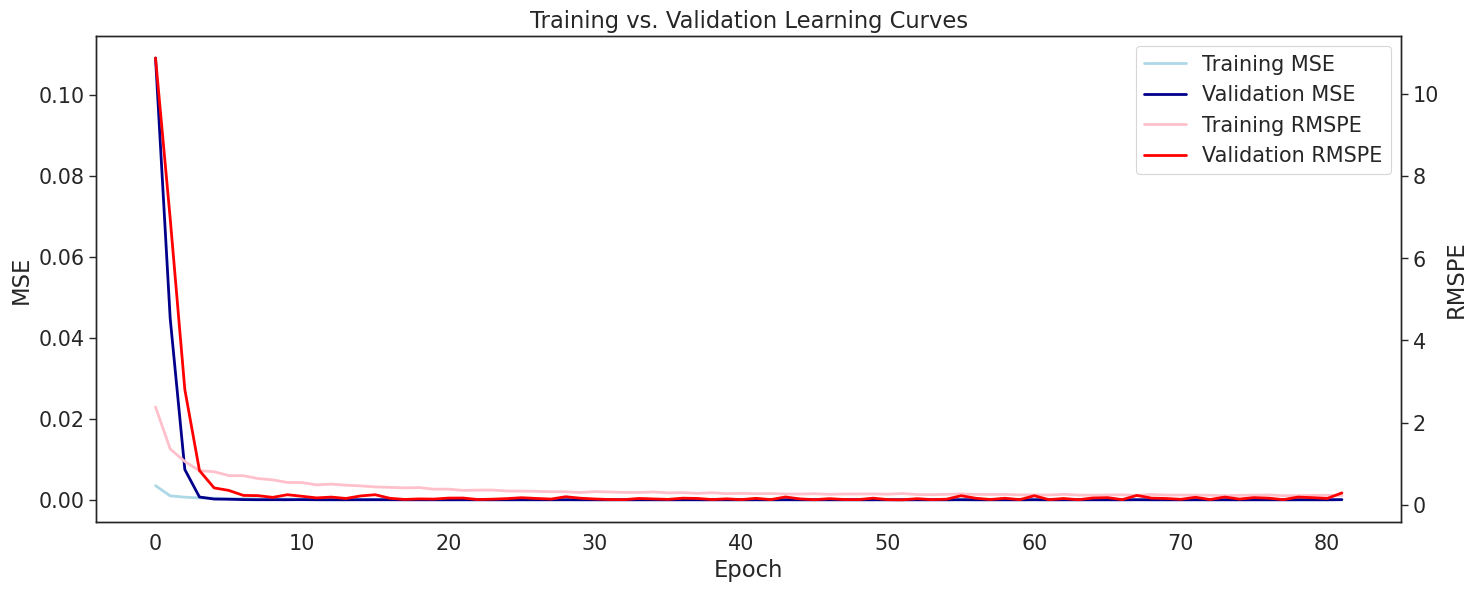

In [146]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [147]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 2s 10ms/step


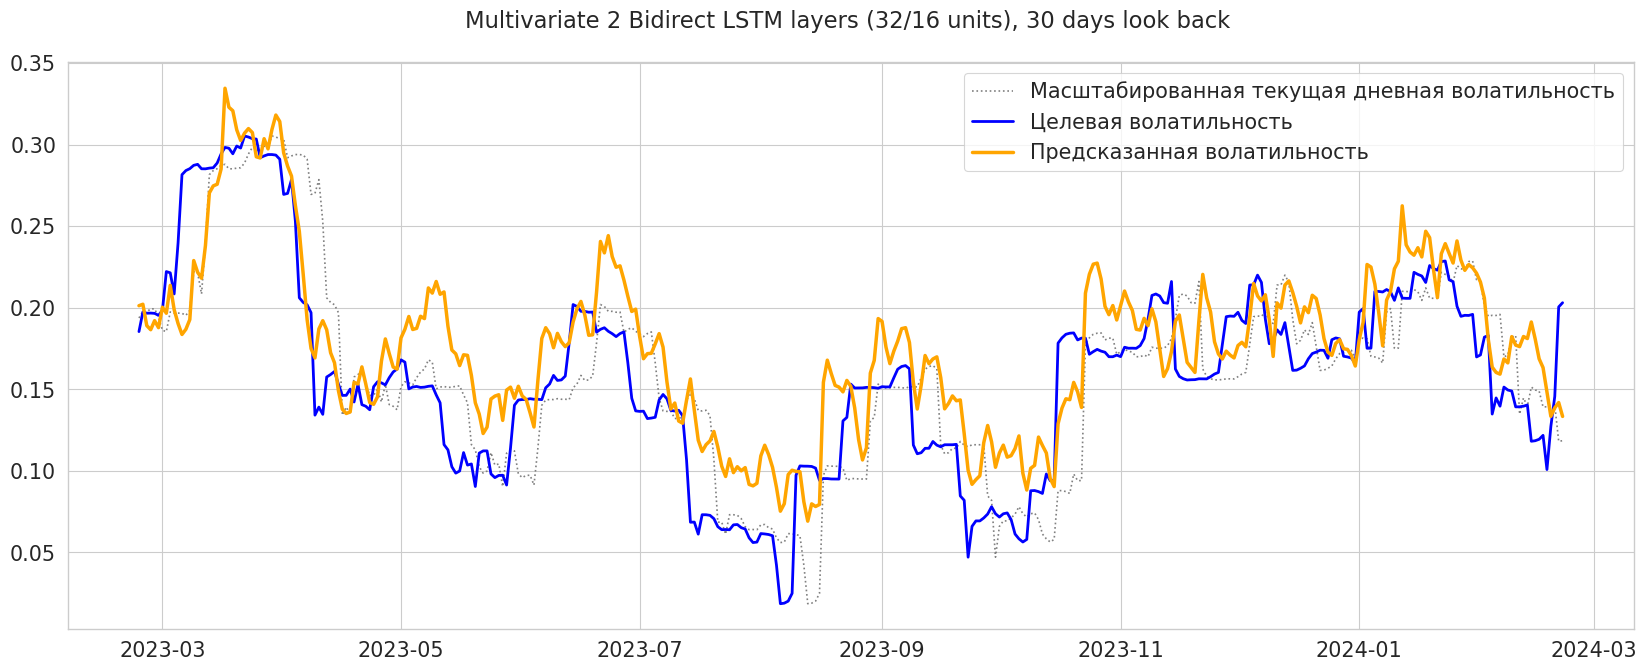

In [148]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.savefig(os.path.join('lstm_5.png'),
            dpi=300)
plt.show();

The prediction line has moved horizontally more towards target lines, and has actually traced the desired output very closely between November 2020 to February 2021. This is certainly an improvement compared to all the previous model. It also doesn't look as noisy as some of the other ones.

In [149]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                 Mean Baseline   
1                                 Random Walk Naive Forecasting   
2                        GARCH(1,1), Constant Mean, Normal Dist   
3        Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4               Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                       Simple LR Fully Connected NN, n_past=14   
6                              LSTM 1 layer 20 units, n_past=14   
7               2 layers Bidirect LSTM (32/16 units), n_past=30   
8  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
9  Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   

   Validation RMSPE  Validation RMSE  
0          2.108653         0.148776  
1          0.352299         0.036363  
2          0.539417         0.094430  
3          0.305346         0.048995  
4          0.386430         0.046375  
5          0.581856         0.043657  
6          0.449882         0.035825  
7          0.362675         0.034445  
8          0.357957         0.034735  
9          0.480720         0.036026

In [150]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [151]:
lstm_2_test_preds = forecast(lstm_2, test_idx)

1/1 [==============================] - 1s 527ms/step


In [152]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [153]:
df.vol_current[:split_time_2].describe()['50%']

0.031871198299934775

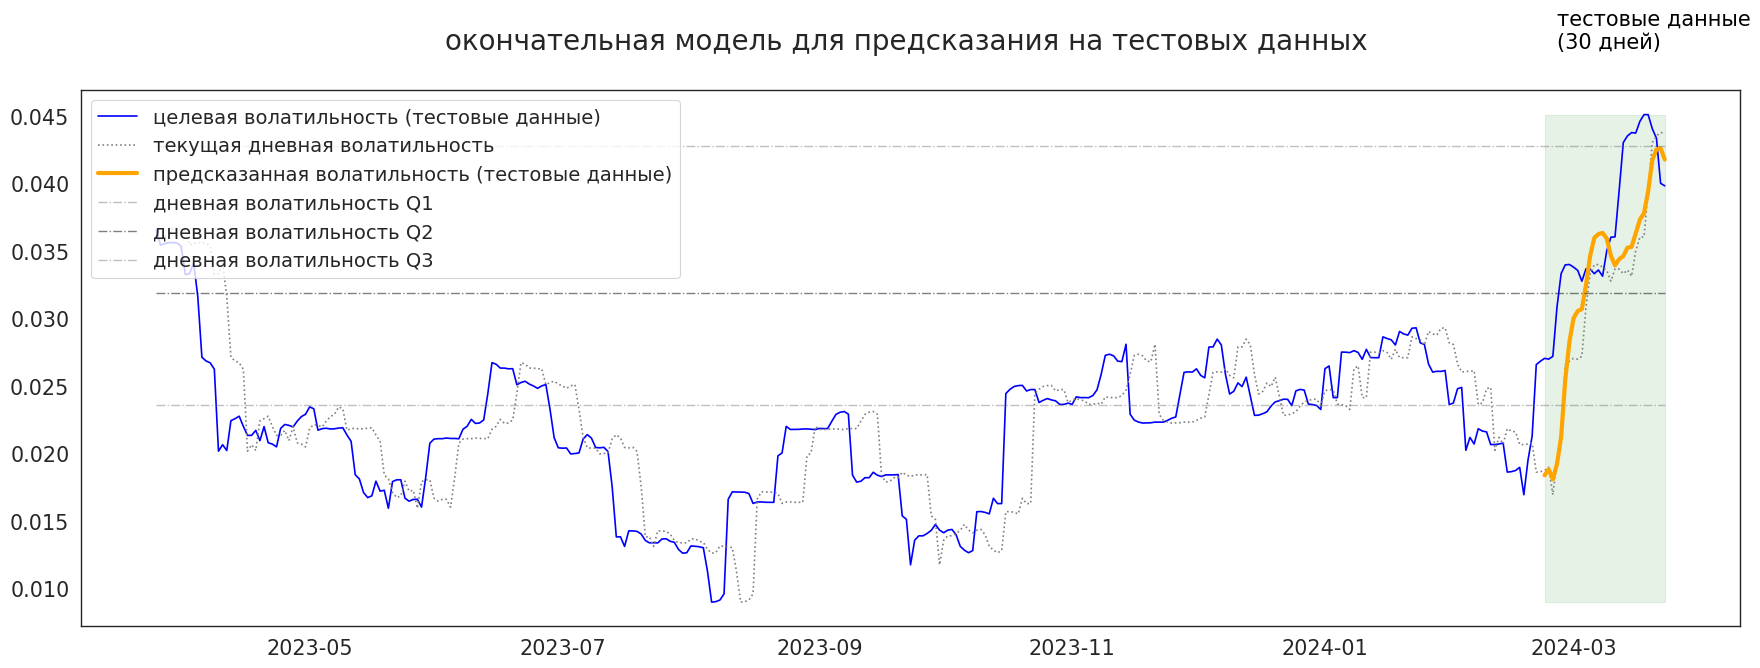

In [154]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"целевая волатильность (тестовые данные)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"текущая дневная волатильность")
    ax1.plot(lstm_2_test_preds, color='orange', lw=3,
                label=f'предсказанная волатильность (тестовые данные)')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'дневная волатильность Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'тестовые данные\n(30 дней)',
             fontsize=15, color='black')

    plt.title(f'окончательная модель для предсказания на тестовых данных \n', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join('final_lstm_test_preds.png'),
            dpi=300, bbox_inches='tight')

    plt.show();

In [155]:
print('RMSPE Двухслойного двунаправленного LSTM на тестовых данных:', RMSPE(y_test, lstm_2_test_preds))

RMSPE Двухслойного двунаправленного LSTM на тестовых данных: 0.17889828682843184
